# Basic Example

In [1]:
import awkward as ak
import numpy as np
import hist
import json
from importlib import resources
import matplotlib.pyplot as plt
import mplhep as hep
from cycler import cycler
from datetime import date
import os
import operator
import xgboost as xgboost

from scipy.optimize import curve_fit
from scipy.integrate import quad # to integrate the exponential fit

In [2]:
acab_palette = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Yellow-green
    "#17becf"   # Cyan
]

plt.rc('axes', prop_cycle=cycler("color", acab_palette))
hep.styles.cms.CMS["axes.prop_cycle"] = cycler("color", acab_palette)
hep.style.use("CMS")

In [3]:
# Get the current date
current_date = date.today()
# Format the date
formatted_date = current_date.strftime("%y%m%d")


In [4]:
def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
    return importance

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [5]:
# Define the exponential function for fitting
def exponential(x, a, b):
    return a * np.exp(b * x)

def calculate_integral(min_, max_, mask_, data_, plotdir, flav_):
    # lead photon eta
    fig, ax0 = plt.subplots(1, 1, figsize=(7, 7))

    # histogram to fit the fucking data sidebands
    ax_ = hist.axis.Regular(80, 100, 180, flow=False, name="ax")
    cax_ = hist.axis.StrCategory(["data"], name="c")
    data_hist = hist.Hist(ax_, cax_)

    data_hist.fill(ax=data_[mask_], c="data")
    # Plot data
    data_hist.plot(ax=ax0, histtype="errorbar", color="black", label="Data")

    # Extract bin centers and contents
    bin_edges = data_hist.axes[0].edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_values = data_hist.values().flatten()

    # Select regions for fitting
    mask_fit = ((bin_centers >= min_) & (bin_centers <= 115)) | ((bin_centers >= 135) & (bin_centers <= max_))
    fit_x = bin_centers[mask_fit]
    fit_y = bin_values[mask_fit]

    # Perform exponential fit
    try:
        # Attempt to fit
        popt, pcov = curve_fit(exponential, fit_x, fit_y, p0=(1, -0.01))  # Initial guess for a, b
        integral, integral_error = quad(exponential, 115, 135, args=tuple(popt))
        fit_x_full = np.linspace(min_, max_, 100)
        fit_y_full = exponential(fit_x_full, *popt)
        print(f"Fit successful: {popt}")
    except RuntimeError as e:
        # Handle the exception (e.g., if the fit fails to converge)
        fit_x_full = np.linspace(min_, max_, 100)
        fit_y_full = ak.zeros_like(fit_x_full)
        print(f"Fit failed: {e}")
        integral = 0  # Append a placeholder
    except Exception as e:
        # Handle other potential exceptions
        fit_x_full = np.linspace(min_, max_, 100)
        fit_y_full = ak.zeros_like(fit_x_full)
        print(f"Unexpected error in fit: {e}")
        integral = 0  # Append a placeholder
    
    print(f"Integral of the fitted function between 115 and 135: {integral:.2f}")
    ax0.plot(fit_x_full, fit_y_full, color="red", linestyle="--", label="Exp. fit")

    # Cosmetics
    ax0.set_ylabel('Events', fontsize=14)
    plot_info = plotdir.split("/")[-1].split("_")
    ax0.set_title(f"fit to sidebands for category {flav}", fontsize=14)
    ax0.tick_params(axis='x', labelsize=10)
    ax0.tick_params(axis='y', labelsize=10)
    ax0.set_xlim([min_, max_])
    ax0.set_xlabel('$m_{\gamma\gamma}$', fontsize=14)
    ax0.grid(color='grey', linestyle='--', alpha=0.5)

    # Add legend
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})

    plt.tight_layout()
    path = plotdir.rsplit('/', 1)[0]

    if not os.path.exists(path):
        print(f"creating plot directory at the path: {path}")
        os.makedirs(path)
    plt.savefig(f'{plotdir}_{flav_}_bkg_fit.pdf')
    plt.close(fig)

    return integral

def calculate_yields(data_, cat_dict):
    # Mapping string operators to actual Python functions
    ops = {
        ">": operator.gt,
        "<": operator.lt,
        ">=": operator.ge,
        "<=": operator.le,
        "==": operator.eq,
        "!=": operator.ne
    }
    mask = ak.ones_like(events["weight_norm"], dtype=bool)  # start with all True
    
    for field, op_str, value in cat_dict["cat_filter"]:
        op_func = ops[op_str]
        
        mask = mask & op_func(events[field], value)
    
    return ak.sum(events["weight_norm"][mask])

def calculate_yields_data(data_, cat_dict):
    # Mapping string operators to actual Python functions
    ops = {
        ">": operator.gt,
        "<": operator.lt,
        ">=": operator.ge,
        "<=": operator.le,
        "==": operator.eq,
        "!=": operator.ne
    }
    mask = ak.ones_like(data_["weight"], dtype=bool)  # start with all True
    
    for field, op_str, value in cat_dict["cat_filter"]:
        op_func = ops[op_str]
        
        mask = mask & op_func(data_[field], value)

    # histogram to fit the fucking data sidebands
    ax_ = hist.axis.Regular(80, 100, 180, flow=False, name="ax")
    cax_ = hist.axis.StrCategory(["data"], name="c")
    data_hist = hist.Hist(ax_, cax_)

    data_hist.fill(ax=data_["CMS_hgg_mass"][mask], c="data")
    # Plot data
    data_hist.plot(ax=ax0, histtype="errorbar", color="black", label="Data")

    # Extract bin centers and contents
    bin_edges = data_hist.axes[0].edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_values = data_hist.values().flatten()

    # Select regions for fitting
    mask_fit = ((bin_centers >= min_) & (bin_centers <= 115)) | ((bin_centers >= 135) & (bin_centers <= max_))
    fit_x = bin_centers[mask_fit]
    fit_y = bin_values[mask_fit]

    # Perform exponential fit
    try:
        # Attempt to fit
        popt, pcov = curve_fit(exponential, fit_x, fit_y, p0=(1, -0.01))  # Initial guess for a, b
        integral, integral_error = quad(exponential, 115, 135, args=tuple(popt))
        fit_x_full = np.linspace(min_, max_, 100)
        fit_y_full = exponential(fit_x_full, *popt)
        print(f"Fit successful: {popt}")
    except RuntimeError as e:
        # Handle the exception (e.g., if the fit fails to converge)
        fit_x_full = np.linspace(min_, max_, 100)
        fit_y_full = ak.zeros_like(fit_x_full)
        print(f"Fit failed: {e}")
        integral = 0  # Append a placeholder
    except Exception as e:
        # Handle other potential exceptions
        fit_x_full = np.linspace(min_, max_, 100)
        fit_y_full = ak.zeros_like(fit_x_full)
        print(f"Unexpected error in fit: {e}")
        integral = 0  # Append a placeholder
    
    return integral

In [6]:
def evaluate_wp(year, nth_jet_pn_b_plus_c, nth_jet_pn_b_vs_c):
    # ParticleNetAK4 -- exclusive b- and c-tagging categories
    # 5x: b-tagged; 4x: c-tagged; 0: light
    _wp_54 = ak.ones_like(nth_jet_pn_b_plus_c) * 54
    _wp_53 = ak.ones_like(nth_jet_pn_b_plus_c) * 53
    _wp_52 = ak.ones_like(nth_jet_pn_b_plus_c) * 52
    _wp_51 = ak.ones_like(nth_jet_pn_b_plus_c) * 51
    _wp_50 = ak.ones_like(nth_jet_pn_b_plus_c) * 50

    _wp_44 = ak.ones_like(nth_jet_pn_b_plus_c) * 44
    _wp_43 = ak.ones_like(nth_jet_pn_b_plus_c) * 43
    _wp_42 = ak.ones_like(nth_jet_pn_b_plus_c) * 42
    _wp_41 = ak.ones_like(nth_jet_pn_b_plus_c) * 41
    _wp_40 = ak.ones_like(nth_jet_pn_b_plus_c) * 40

    _wp_0 = ak.zeros_like(nth_jet_pn_b_plus_c)
    wp = ak.zeros_like(nth_jet_pn_b_plus_c)

    if str(year) in ("2017", "2018", "combined"):
        # b WPs
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.5) & (nth_jet_pn_b_vs_c > 0.99),
            _wp_54,
            wp
        )
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.5) & (0.96 < nth_jet_pn_b_vs_c) & (nth_jet_pn_b_vs_c <= 0.99),
            _wp_53,
            wp
        )
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.5) & (0.88 < nth_jet_pn_b_vs_c) & (nth_jet_pn_b_vs_c <= 0.96),
            _wp_52,
            wp
        )
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.5) & (0.70 < nth_jet_pn_b_vs_c) & (nth_jet_pn_b_vs_c <= 0.88),
            _wp_51,
            wp
        )
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.5) & (0.40 < nth_jet_pn_b_vs_c) & (nth_jet_pn_b_vs_c <= 0.70),
            _wp_50,
            wp
        )

        # c WPs
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.5) & (nth_jet_pn_b_vs_c <= 0.05),
            _wp_44,
            wp
        )
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.5) & (0.05 < nth_jet_pn_b_vs_c) & (nth_jet_pn_b_vs_c <= 0.15),
            _wp_43,
            wp
        )
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.5) & (0.15 < nth_jet_pn_b_vs_c) & (nth_jet_pn_b_vs_c <= 0.40),
            _wp_42,
            wp
        )
        wp = ak.where(
            (0.2 < nth_jet_pn_b_plus_c) & (nth_jet_pn_b_vs_c <= 0.5),
            _wp_41,
            wp
        )
        wp = ak.where(
            (0.1 < nth_jet_pn_b_plus_c) & (nth_jet_pn_b_vs_c <= 0.2),
            _wp_40,
            wp
        )

        # light wp
        wp = ak.where(
            (nth_jet_pn_b_plus_c <= 0.1),
            _wp_0,
            wp
        )

    else:
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.35) & (nth_jet_pn_b_vs_c > 0.99),
            _wp_54,
            wp
        )
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.35) & (0.96 < nth_jet_pn_b_vs_c) & (nth_jet_pn_b_vs_c <= 0.99),
            _wp_53,
            wp
        )
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.35) & (0.88 < nth_jet_pn_b_vs_c) & (nth_jet_pn_b_vs_c <= 0.96),
            _wp_52,
            wp
        )
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.35) & (0.70 < nth_jet_pn_b_vs_c) & (nth_jet_pn_b_vs_c <= 0.88),
            _wp_51,
            wp
        )
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.35) & (0.40 < nth_jet_pn_b_vs_c) & (nth_jet_pn_b_vs_c <= 0.70),
            _wp_50,
            wp
        )

        # c WPs
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.35) & (nth_jet_pn_b_vs_c <= 0.05),
            _wp_44,
            wp
        )
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.35) & (0.05 < nth_jet_pn_b_vs_c) & (nth_jet_pn_b_vs_c <= 0.15),
            _wp_43,
            wp
        )
        wp = ak.where(
            (nth_jet_pn_b_plus_c > 0.35) & (0.15 < nth_jet_pn_b_vs_c) & (nth_jet_pn_b_vs_c <= 0.40),
            _wp_42,
            wp
        )
        wp = ak.where(
            (0.17 < nth_jet_pn_b_plus_c) & (nth_jet_pn_b_vs_c <= 0.35),
            _wp_41,
            wp
        )
        wp = ak.where(
            (0.1 < nth_jet_pn_b_plus_c) & (nth_jet_pn_b_vs_c <= 0.17),
            _wp_40,
            wp
        )

        # light wp
        wp = ak.where(
            (nth_jet_pn_b_plus_c <= 0.1),
            _wp_0,
            wp
        )

    print("wp:", wp)
    return wp

In [8]:
year = 2018

In [9]:
MULTICLASS = True
SPLIT = False

if SPLIT:
    processes = [
        "bH_5FS_FXFX_M125_2017_b",
        "bH_5FS_FXFX_M125_2017_c",
        "bH_5FS_FXFX_M125_2017_l",
        "cH_4FS_FXFX_M125_2017_b",
        "cH_4FS_FXFX_M125_2017_c",
        "cH_4FS_FXFX_M125_2017_l",
        "ggh_M125_2017_b",
        "ggh_M125_2017_c",
        "ggh_M125_2017_l",
        "tth_M125_2017_b",
        "tth_M125_2017_c",
        "tth_M125_2017_l",
        "vbf_M125_2017_b",
        "vbf_M125_2017_c",
        "vbf_M125_2017_l",
        "vh_M125_2017_b",
        "vh_M125_2017_c",
        "vh_M125_2017_l",
        "THQ_HToGG_2017_b",
        "THQ_HToGG_2017_c",
        "THQ_HToGG_2017_l",
        "THW_HToGG_2017_b",
        "THW_HToGG_2017_c",
        "THW_HToGG_2017_l",
    ]

    ext = f"{formatted_date}_split_cats"
    cats = [
        "bTag_high",
        "bTag_low",
        "cTag_high",
        "cTag_low",
        "tthTag",
        "vhTag",
        "vbfTag",
        #"lTag",
        "lTag_high",
        "lTag_low"
    ]
else:
    processes = [
        f"bH_5FS_FXFX_M125_{year}",
        f"cH_4FS_FXFX_M125_{year}",
        f"ggh_M125_{year}",
        f"tth_M125_{year}",
        f"vbf_M125_{year}",
        f"vh_M125_{year}",
        f"THQ_HToGG_{year}",
        f"THW_HToGG_{year}"
    ]

    ext = f"{formatted_date}_no_cats"
    cats = [
        "NOTAG"
    ]
        

In [11]:
fileset = {}
fileset_data = {}
DATA = True
for i, proc in enumerate(processes):
    fileset[proc] = {}
    if year == 2016:
        #input_dir = f"/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2016_250509/merged_nocat/{proc}/nominal" 
        input_dir = f"/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2016_250814/merged_nocat/{proc}/" 
    elif year == 2017:
        # input_dir = f"/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/ggHvsRB_training_2017/HpC_NewBDT_250525/merged/{proc}/nominal" 
        input_dir = f"/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2017_250804/output_2017/merged/{proc}/nominal" 
    elif year == 2018:
        # input_dir = f"/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2018_250506/merged_nocat/{proc}/" 
        input_dir = f"/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2018_250808/merged/{proc}/" 
    for cat in cats:
        print(f"{input_dir}/{cat}_merged.parquet")
        fileset[proc][cat] = ak.from_parquet(f"{input_dir}/{cat}_merged.parquet")
if DATA:
    if year == 2016:
        #input_dir_data = f"/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2016_250509/merged_nocat/Data_2016" 
        input_dir_data = f"/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2016_250814/merged_nocat/Data_2016" 
    elif year == 2017:
        #input_dir_data = f"/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/HpC_new_BDTs_250425/merged_nocat/Data_2017"
        input_dir_data = f"/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2017_250804/output_2017/merged/Data_2017"
    elif year == 2018:
        #input_dir_data = f"/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2018_250506/merged_nocat/Data_2018"
        input_dir_data = f"/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2018_250808/merged/Data_2018/"
    for cat in cats:
        print(f"{input_dir_data}/allData_{cat}_merged.parquet")
        fileset_data[cat] = ak.from_parquet(f"{input_dir_data}/allData_{cat}_merged.parquet")


/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2018_250808/merged/bH_5FS_FXFX_M125_2018//NOTAG_merged.parquet
/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2018_250808/merged/cH_4FS_FXFX_M125_2018//NOTAG_merged.parquet
/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2018_250808/merged/ggh_M125_2018//NOTAG_merged.parquet
/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2018_250808/merged/tth_M125_2018//NOTAG_merged.parquet
/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2018_250808/merged/vbf_M125_2018//NOTAG_merged.parquet
/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newBDT_2018_250808/merged/vh_M125_2018//NOTAG_merged.parquet
/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/fit_newB

In [12]:
lumi = {
    "2016" : 35.9,
    "2017" : 41.5,
    "2018" : 59.2
}

norm_1fb = {
    "ggh": 48.58 * 0.00227 * 1000,
    "tth": 0.5071 * 0.00227 * 1000,
    "thw": 0.01517 * 0.00227 * 1000,
    "thq": 0.07425 * 0.00227 * 1000,
    "vbf": 3.782 * 0.00227 * 1000,
    "vh": 2.2555 * 0.00227 * 1000,
    "bh": 0.6654 * 0.00227 * 1000,
    "ch": 0.09013 * 0.00227 * 1000,
}

In [13]:
for f in fileset[[*processes][0]][[*cats][0]].fields:
    if "eight" not in f:
        print(f)

bdt_score
dZ
CMS_hgg_mass
event
pt
eta
phi
dijet_pt
dijet_eta
dijet_phi
dijet_mass
LeadPhoton_pt_mgg
LeadPhoton_eta
LeadPhoton_mvaID
SubleadPhoton_pt_mgg
SubleadPhoton_eta
SubleadPhoton_mvaID
LeadPhoton_pt
SubleadPhoton_pt
LeadPhoton_energy
SubleadPhoton_energy
Diphoton_cos_dPhi
sigmaMrv
PV_score
nPV
nPU
rho
n_jets
n_c_had
n_b_had
n_ME_c_in
n_ME_b_in
n_ME_l_in
n_ME_g_in
n_ME_c_out
n_ME_b_out
n_ME_l_out
n_ME_g_out
charmed_flag
bottom_flag
charmed_flag_gen
bottom_flag_gen
n_b_jets_loose
n_b_jets_medium
first_jet_pt
first_jet_eta
first_jet_phi
first_jet_mass
first_jet_hFlav
first_jet_DeepFlavour_CvsL
first_jet_DeepFlavour_CvsB
first_jet_DeepFlavour_B
first_jet_DeepFlavour_QG
first_jet_particleNetAK4_CvsL
first_jet_particleNetAK4_CvsB
first_jet_particleNetAK4_QvsG
first_jet_particleNetAK4_B
first_jet_jet_pn_b
first_jet_jet_pn_c
first_jet_jet_pn_uds
first_jet_jet_pn_g
first_jet_jet_pn_b_plus_c
first_jet_jet_pn_b_vs_c
first_jet_n_sv
first_jet_n_muons
first_jet_n_electrons
first_pt_jet_pt
fir

In [14]:
yields = {}
yields_proc = {
    "ggh": {},
    "ggh_c": {},
    "ggh_b": {},
    "ggh_l": {},
    "tth": {},
    "vbf": {},
    "vh": {},
    "bh": {},
    "bh_c": {},
    "bh_b": {},
    "bh_l": {},
    "ch": {},
    "ch_c": {},
    "ch_b": {},
    "ch_l": {},
    "thq": {},
    "thw": {},
    "h_c": {},
    "h_b": {},
    "h_l": {},
    "data": {},
}

yields_cats = {}
for c in cats:
    yields_cats[c] = 0.

for sample in yields_proc:
    if sample in ["ggh", "bh", "ch"]:
        for flav in ["c", "b", "l"]:
            yields_proc[f"{sample}_{flav}"]["tot"] = 0
    yields_proc[sample]["tot"] = 0
    for cat in cats:
        yields_proc[sample][cat] = 0
        if sample in ["ggh", "bh", "ch"]:
            for flav in ["c", "b", "l"]:
                yields_proc[f"{sample}_{flav}"][cat] = 0

for sample in [*fileset]:
    print("-"*60)
    print("sample:", sample)
    yields[sample] = {}
    yields[sample]["tot"] = 0
    tot_num_ev = 0

    for cat in cats:
        if len(fileset[sample][cat].weight) and (ak.sum(fileset[sample][cat]["weight"]) > 0):
            fileset[sample][cat]["weight_norm"] = fileset[sample][cat].weight * norm_1fb[sample.split("_")[0].lower()] * lumi[f"{year}"]
            fileset[sample][cat]["square_weight"] = fileset[sample][cat].weight_norm ** 2
            yields[sample][cat] = ak.sum(fileset[sample][cat]["weight_norm"])
            yields[sample]["tot"] += ak.sum(fileset[sample][cat]["weight_norm"])
            yields_proc[sample.split("_")[0].lower()][cat] += ak.sum(fileset[sample][cat]["weight_norm"])
            yields_proc[sample.split("_")[0].lower()]["tot"] += ak.sum(fileset[sample][cat]["weight_norm"])
            tot_num_ev += len(fileset[sample][cat]["weight_norm"])

            if (("ggh" in sample) or ("ch" in sample.lower()) or ("bh" in sample.lower())) and SPLIT:
                yields_proc[f"{sample.split('_')[0].lower()}_{sample.split('_')[-1].lower()}"][cat] += ak.sum(fileset[sample][cat]["weight_norm"])
                yields_proc[f"{sample.split('_')[0].lower()}_{sample.split('_')[-1].lower()}"]["tot"] += ak.sum(fileset[sample][cat]["weight_norm"])
                yields_proc[f"h_{sample.split('_')[-1].lower()}"][cat] += ak.sum(fileset[sample][cat]["weight_norm"])
                yields_proc[f"h_{sample.split('_')[-1].lower()}"]["tot"] += ak.sum(fileset[sample][cat]["weight_norm"])

            yields_cats[cat] += ak.sum(fileset[sample][cat]["weight_norm"])

            print(f"{'   -':<5} {cat:<15} {'events':<10} {yields[sample][cat]:<10.3f}")
            print(f"{'   -':<5} {cat:<15} {'tot events':<10} {yields[sample]['tot']:<10.3f}")
            print(f"{'   -':<5} {cat:<15} {'num events':<10} {tot_num_ev:<10}")
        else:
            fileset[sample][cat]["weight_norm"] = 0
            fileset[sample][cat]["square_weight"] = 0
            yields[sample][cat] = 0
            print("   - cat:", cat, "events", 0), 
if DATA:
    sample = "data"
    print("-"*60)
    print("sample:", sample)
    yields[sample] = {}
    yields[sample]["tot"] = 0
    tot_num_ev = 0
    for cat in cats:
        if len(fileset_data[cat].weight) and (ak.sum(fileset_data[cat]["weight"]) > 0):
            if not os.path.isdir(f"plots/fit_{formatted_date}/"):
                os.makedirs(f"plots/fit_{formatted_date}/")
            mask = (fileset_data[cat]["CMS_hgg_mass"] > 135) | (fileset_data[cat]["CMS_hgg_mass"] < 115)
            integral = calculate_integral(110, 180, mask, fileset_data[cat]["CMS_hgg_mass"], f"plots/fit_{formatted_date}/{cat}", f"fit {cat}")
                        
            yields[sample][cat] = integral #ak.sum(fileset_data[cat]["weight"])
            yields[sample]["tot"] += integral # ak.sum( fileset_data[cat]["weight"])
            yields_proc[sample.split("_")[0].lower()][cat] += integral # ak.sum(fileset_data[cat]["weight"])
            yields_proc[sample.split("_")[0].lower()]["tot"] += integral # ak.sum(fileset_data[cat]["weight"])
            tot_num_ev += len(fileset_data[cat]["weight"])
            yields_cats[cat] += integral # ak.sum(fileset_data[cat]["weight"])
            print(f"{'   -':<5} {cat:<15} {'events':<10} {yields[sample][cat]:<10.3f}")
            print(f"{'   -':<5} {cat:<15} {'tot events':<10} {yields[sample]['tot']:<10.3f}")
            print(f"{'   -':<5} {cat:<15} {'num events':<10} {tot_num_ev:<10}")
        else:
            yields[sample][cat] = 0
            print("   - cat:", cat, "events", 0), 

------------------------------------------------------------
sample: bH_5FS_FXFX_M125_2018
   -  NOTAG           events     21.412    
   -  NOTAG           tot events 21.412    
   -  NOTAG           num events 1092070   
------------------------------------------------------------
sample: cH_4FS_FXFX_M125_2018
   -  NOTAG           events     2.830     
   -  NOTAG           tot events 2.830     
   -  NOTAG           num events 1262034   
------------------------------------------------------------
sample: ggh_M125_2018
   -  NOTAG           events     1444.970  
   -  NOTAG           tot events 1444.970  
   -  NOTAG           num events 261153    
------------------------------------------------------------
sample: tth_M125_2018
   -  NOTAG           events     26.667    
   -  NOTAG           tot events 26.667    
   -  NOTAG           num events 376083    
------------------------------------------------------------
sample: vbf_M125_2018
   -  NOTAG           events     159.841 

In [15]:
# Manipulate fields to adjust missing fields
for sample in [*fileset]:
    for cat in cats:
        fileset[sample][cat]["dEta_ljh"] = abs(fileset[sample][cat].eta - fileset[sample][cat].first_pt_jet_eta)
        fileset[sample][cat]["dEta_sljh"] = ak.where(
            fileset[sample][cat]["second_jet_eta"] != -999.,
            abs(fileset[sample][cat].eta - fileset[sample][cat].second_pt_jet_eta),
            ak.ones_like(fileset[sample][cat].second_jet_eta) * -1
        )
        fileset[sample][cat]["dEta_ljslj"] = ak.where(
            fileset[sample][cat]["second_jet_eta"] != -999.,
            abs(fileset[sample][cat].first_pt_jet_eta - fileset[sample][cat].second_pt_jet_eta),
            ak.ones_like(fileset[sample][cat].second_jet_eta) * -1
        )
        fileset[sample][cat]["dR_ljlp"] = np.sqrt((fileset[sample][cat].LeadPhoton_eta - fileset[sample][cat].first_jet_eta)**2 + (fileset[sample][cat].DeltaPhi_gamma1_cjet)**2)
        fileset[sample][cat]["dR_ljslp"] = np.sqrt((fileset[sample][cat].SubleadPhoton_eta - fileset[sample][cat].first_jet_eta)**2 + (fileset[sample][cat].DeltaPhi_gamma2_cjet)**2)
        
        fileset[sample][cat]["lj_ptoM"] = fileset[sample][cat].first_jet_pt / fileset[sample][cat].first_jet_mass
        
        fileset[sample][cat]["slj_ptoM"] =  ak.where(
            fileset[sample][cat].second_jet_pt != -999,
            fileset[sample][cat].second_jet_pt / fileset[sample][cat].second_jet_mass,
            ak.ones_like(fileset[sample][cat].second_jet_pt) * -1
        )
        fileset[sample][cat]["lj_ptoM"] = ak.where(
                fileset[sample][cat]["lj_ptoM"] > 50000,
                ak.ones_like(fileset[sample][cat].lj_ptoM) * 50000,
                fileset[sample][cat]["lj_ptoM"]
        )
        fileset[sample][cat]["slj_ptoM"] = ak.where(
                fileset[sample][cat]["slj_ptoM"] > 50000,
                ak.ones_like(fileset[sample][cat].slj_ptoM) * 50000,
                fileset[sample][cat]["slj_ptoM"]
        )
        fileset[sample][cat]["lj_ptoM"] = ak.where(
                fileset[sample][cat]["lj_ptoM"] < -1.,
                ak.ones_like(fileset[sample][cat].lj_ptoM) * -1,
                fileset[sample][cat]["lj_ptoM"]
        )
        fileset[sample][cat]["slj_ptoM"] = ak.where(
                fileset[sample][cat]["slj_ptoM"] < -1.,
                ak.ones_like(fileset[sample][cat].slj_ptoM) * -1,
                fileset[sample][cat]["slj_ptoM"]
        )
        fileset[sample][cat]["first_muon_pt"] = ak.where(
                fileset[sample][cat]["first_muon_pt"] < 0,
                ak.ones_like(fileset[sample][cat].first_muon_pt) * -1,
                fileset[sample][cat]["first_muon_pt"]
        )
        fileset[sample][cat]["first_electron_pt"] = ak.where(
                fileset[sample][cat]["first_electron_pt"] < 0,
                ak.ones_like(fileset[sample][cat].first_electron_pt) * -1,
                fileset[sample][cat]["first_electron_pt"]
        )
        print(sample)
        fileset[sample][cat]["first_jet_wp"] = evaluate_wp(year, fileset[sample][cat].first_jet_jet_pn_b_plus_c, fileset[sample][cat].first_jet_jet_pn_b_vs_c)
        fileset[sample][cat]["second_jet_wp"] = evaluate_wp(year, fileset[sample][cat].second_jet_jet_pn_b_plus_c, fileset[sample][cat].second_jet_jet_pn_b_vs_c)
        fileset[sample][cat]["third_jet_wp"] = evaluate_wp(year, fileset[sample][cat].third_jet_jet_pn_b_plus_c, fileset[sample][cat].third_jet_jet_pn_b_vs_c)

bH_5FS_FXFX_M125_2018
wp: [54, 0, 41, 0, 0, 51, 51, 53, 0, 51, 0, ... 0, 54, 53, 0, 54, 51, 53, 51, 54, 0, 0]
wp: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
wp: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cH_4FS_FXFX_M125_2018
wp: [0, 0, 0, 40, 0, 0, 0, 40, 0, 40, 40, 0, ... 0, 0, 41, 51, 0, 50, 0, 50, 0, 0, 0, 0]
wp: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
wp: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ggh_M125_2018
wp: [41, 0, 0, 0, 0, 0, 0, 41, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0]
wp: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
wp: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tth_M125_2018
wp: [50, 54, 51, 53, 54, 40, 50, 40, 54, 41, ... 54, 54, 41, 53, 52, 40, 50, 53, 54, 54]
wp: [54, 52, 52, 52, 52, 51, 40,

In [16]:
for cat in cats:
        fileset_data[cat]["dEta_ljh"] = abs(fileset_data[cat].eta - fileset_data[cat].first_pt_jet_eta)
        fileset_data[cat]["dEta_sljh"] = ak.where(
            fileset_data[cat]["second_jet_eta"] != -999.,
            abs(fileset_data[cat].eta - fileset_data[cat].second_pt_jet_eta),
            ak.ones_like(fileset_data[cat].second_jet_eta) * -1
        )
        fileset_data[cat]["dEta_ljslj"] = ak.where(
            fileset_data[cat]["second_jet_eta"] != -999.,
            abs(fileset_data[cat].first_pt_jet_eta - fileset_data[cat].second_pt_jet_eta),
            ak.ones_like(fileset_data[cat].second_jet_eta) * -1
        )
        fileset_data[cat]["dR_ljlp"] = np.sqrt((fileset_data[cat].LeadPhoton_eta - fileset_data[cat].first_jet_eta)**2 + (fileset_data[cat].DeltaPhi_gamma1_cjet)**2)
        fileset_data[cat]["dR_ljslp"] = np.sqrt((fileset_data[cat].SubleadPhoton_eta - fileset_data[cat].first_jet_eta)**2 + (fileset_data[cat].DeltaPhi_gamma2_cjet)**2)
        
        fileset_data[cat]["lj_ptoM"] = fileset_data[cat].first_jet_pt / fileset_data[cat].first_jet_mass
        
        fileset_data[cat]["slj_ptoM"] =  ak.where(
            fileset_data[cat].second_jet_pt != -999,
            fileset_data[cat].second_jet_pt / fileset_data[cat].second_jet_mass,
            ak.ones_like(fileset_data[cat].second_jet_pt) * -1
        )
        fileset_data[cat]["lj_ptoM"] = ak.where(
                fileset_data[cat]["lj_ptoM"] > 50000,
                ak.ones_like(fileset_data[cat].lj_ptoM) * 50000,
                fileset_data[cat]["lj_ptoM"]
        )
        fileset_data[cat]["slj_ptoM"] = ak.where(
                fileset_data[cat]["slj_ptoM"] > 50000,
                ak.ones_like(fileset_data[cat].slj_ptoM) * 50000,
                fileset_data[cat]["slj_ptoM"]
        )
        fileset_data[cat]["lj_ptoM"] = ak.where(
                fileset_data[cat]["lj_ptoM"] < -1.,
                ak.ones_like(fileset_data[cat].lj_ptoM) * -1,
                fileset_data[cat]["lj_ptoM"]
        )
        fileset_data[cat]["slj_ptoM"] = ak.where(
                fileset_data[cat]["slj_ptoM"] < -1.,
                ak.ones_like(fileset_data[cat].slj_ptoM) * -1,
                fileset_data[cat]["slj_ptoM"]
        )
        fileset_data[cat]["first_muon_pt"] = ak.where(
                fileset_data[cat]["first_muon_pt"] < 0,
                ak.ones_like(fileset_data[cat].first_muon_pt) * -1,
                fileset_data[cat]["first_muon_pt"]
        )
        fileset_data[cat]["first_electron_pt"] = ak.where(
                fileset_data[cat]["first_electron_pt"] < 0,
                ak.ones_like(fileset_data[cat].first_electron_pt) * -1,
                fileset_data[cat]["first_electron_pt"]
        )
        fileset_data[cat]["first_jet_wp"] = evaluate_wp(year, fileset_data[cat].first_jet_jet_pn_b_plus_c, fileset_data[cat].first_jet_jet_pn_b_vs_c)
        fileset_data[cat]["second_jet_wp"] = evaluate_wp(year, fileset_data[cat].second_jet_jet_pn_b_plus_c, fileset_data[cat]. second_jet_jet_pn_b_vs_c)
        fileset_data[cat]["third_jet_wp"] = evaluate_wp(year, fileset_data[cat].third_jet_jet_pn_b_plus_c, fileset_data[cat].third_jet_jet_pn_b_vs_c)

wp: [40, 40, 41, 40, 41, 40, 40, 40, 41, 0, 40, ... 0, 0, 41, 0, 40, 40, 0, 40, 41, 40]
wp: [40, 0, 40, 0, 0, 0, 0, 0, 40, 0, 0, 41, ... 41, 0, 0, 0, 41, 0, 40, 0, 0, 0, 50, 0]
wp: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [17]:
config = "/work/bevila_t/HpC_Analysis/ggHvOthers_BDT_training/inputs/ggH_vs_other_bdt_config_2p0.json"
# xgb_model_dir = "/work/bevila_t/HpC_Analysis/ggHvOthers_BDT_training/plots/250430/combined"
# wgt_model = "weights_250509_MET_bjets_ssljet_dijet_multiclass_TH_2_2016"
# xgb_model_dir = "/work/bevila_t/HpC_Analysis/ggHvOthers_BDT_training/plots/250430/combined"
#wgt_model = "weights_250430_MET_bjets_ssljet_dijet_multiclass_TH_2_2018"
#xgb_model_dir = "/work/bevila_t/HpC_Analysis/ggHvOthers_BDT_training/XGBoost_models"
# wgt_model = "weights_250430_MET_bjets_ssljet_dijet_multiclass_TH_2_2017"
xgb_model_dir = "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master_250721/higgs-dna-tiziano-bevilacqua/higgs_dna/metaconditions/hpc_bdt"
if year in [2017, 2018]:
    wgt_model = "weights_250430_MET_bjets_ssljet_dijet_multiclass_TH_2_2018"
if year == 2016:
    wgt_model = "weights_250509_MET_bjets_ssljet_dijet_multiclass_TH_2_2016"
labels_ = ["sig", "tth", "vbf", "vh"]

print(f"Loading BDT configuration from: {config}")

with open(config, "r") as f_in:
    bdt_config = json.load(f_in)

bdt = []
for set in ["even", "odd"]:
    print("loading model...")
    print(f"{xgb_model_dir}/{wgt_model}_{set}.xgb")
    model = xgboost.Booster()
    model.load_model(f"{xgb_model_dir}/{wgt_model}_{set}.xgb")
    bdt.append(model)
    imp = get_importance(model, bdt_config["features"])
    print('Importance array: ', imp)
    print("|"+"-"*10+"importance"+"-"*10+"|")
    for var in imp:
        print("| {:20} : {: >5} |".format(var[0], var[1]))
    print("|"+"-"*30+"|")

for sample in [*fileset]:
    print("-"*60)
    print("evaluating BDT for sample:", sample)
    for cat in cats:
        features = ak.to_numpy(fileset[sample][cat][bdt_config["features"]])
        features = features.view((float, len(features.dtype.names)))
        bdt_score_0 = bdt[1].predict(xgboost.DMatrix(features, feature_names=bdt_config["features"]))
        bdt_score_1 = bdt[0].predict(xgboost.DMatrix(features, feature_names=bdt_config["features"]))
        bdt_score = ak.concatenate([bdt_score_0, bdt_score_1])

        for i in range(bdt_config["mva"]["param"]["num_class"]):
            fileset[sample][cat][f"mva_score_{labels_[i]}"] = ak.where(
                fileset[sample][cat].event % 2 == 0,
                bdt_score_0[:, i],
                bdt_score_1[:, i]
            )
        scores = [ak.singletons(fileset[sample][cat][f"mva_score_{labels_[x]}"]) for x in range(bdt_config["mva"]["param"]["num_class"])]
        fileset[sample][cat]["mva_score"] = ak.concatenate(scores, axis=1)

for cat in cats:
    print("-"*60)
    print("evaluating BDT for sample:", "data")
    features = ak.to_numpy(fileset_data[cat][bdt_config["features"]])
    features = features.view((float, len(features.dtype.names)))
    bdt_score_0 = bdt[1].predict(xgboost.DMatrix(features, feature_names=bdt_config["features"]))
    bdt_score_1 = bdt[0].predict(xgboost.DMatrix(features, feature_names=bdt_config["features"]))
    bdt_score = ak.concatenate([bdt_score_0, bdt_score_1])

    for i in range(bdt_config["mva"]["param"]["num_class"]):
        fileset_data[cat][f"mva_score_{labels_[i]}"] = ak.where(
            fileset_data[cat].event % 2 == 0,
            bdt_score_0[:, i],
            bdt_score_1[:, i]
        )
    scores = [ak.singletons(fileset_data[cat][f"mva_score_{labels_[x]}"]) for x in range(bdt_config["mva"]["param"]["num_class"])]
    fileset_data[cat]["mva_score"] = ak.concatenate(scores, axis=1)

Loading BDT configuration from: /work/bevila_t/HpC_Analysis/ggHvOthers_BDT_training/inputs/ggH_vs_other_bdt_config_2p0.json
loading model...
/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master_250721/higgs-dna-tiziano-bevilacqua/higgs_dna/metaconditions/hpc_bdt/weights_250430_MET_bjets_ssljet_dijet_multiclass_TH_2_2018_even.xgb


Importance array:  [('pt', 4479.0), ('PV_score', 3652.0), ('MET_significance', 3592.0), ('first_jet_wp', 3415.0), ('first_jet_pt', 3328.0), ('dijet_pt', 3227.0), ('second_jet_pt', 3159.0), ('dijet_mass', 3012.0), ('dEta_ljh', 2973.0), ('dEta_ljslj', 2859.0), ('lj_ptoM', 2700.0), ('dR_ljlp', 2560.0), ('third_jet_pt', 2327.0), ('n_jets', 2297.0), ('MET_pt', 2286.0), ('MET_sumEt', 2125.0), ('DeltaPhi_gamma1_cjet', 2112.0), ('first_muon_pt', 2109.0), ('second_jet_mass', 2027.0), ('nTau', 1745.0), ('second_jet_wp', 1613.0), ('first_jet_eta', 1579.0), ('dEta_sljh', 1577.0), ('second_jet_eta', 1479.0), ('LeadPhoton_pt_mgg', 1429.0), ('third_jet_mass', 1427.0), ('DeltaPhi_gamma2_cjet', 1421.0), ('Diphoton_cos_dPhi', 1274.0), ('third_jet_eta', 1270.0), ('first_jet_mass', 1256.0), ('eta', 1254.0), ('dijet_eta', 1244.0), ('LeadPhoton_eta', 1216.0), ('first_electron_eta', 1045.0), ('SubleadPhoton_eta', 953.0), ('SubleadPhoton_pt_mgg', 895.0), ('MET_phi', 635.0), ('first_muon_eta', 526.0), ('third_

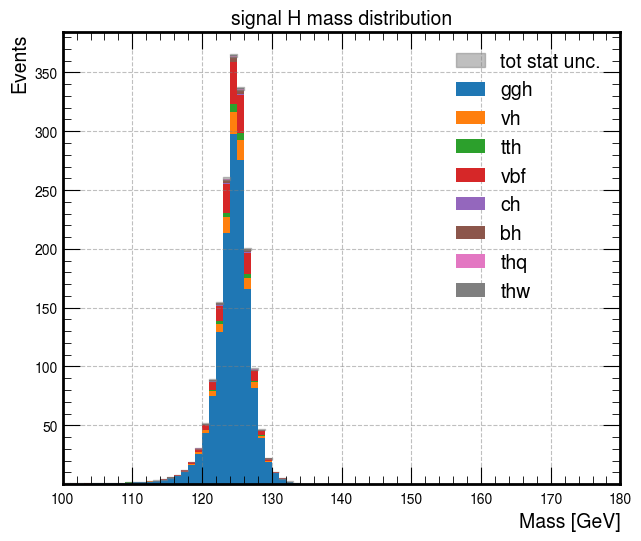

In [18]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 6))

title = "signal H mass distribution"
var = "CMS_hgg_mass"
min_ = 100.
max_ = 180
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["thw", "thq", "bh", "ch", "vbf", "tth", "vh",  "ggh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            full_hist.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["weight_norm"], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["square_weight"], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["weight_norm"], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["square_weight"], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()

ax0.set_xlim([min_, max_])
ax0.set_xlabel('Mass [GeV]', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()

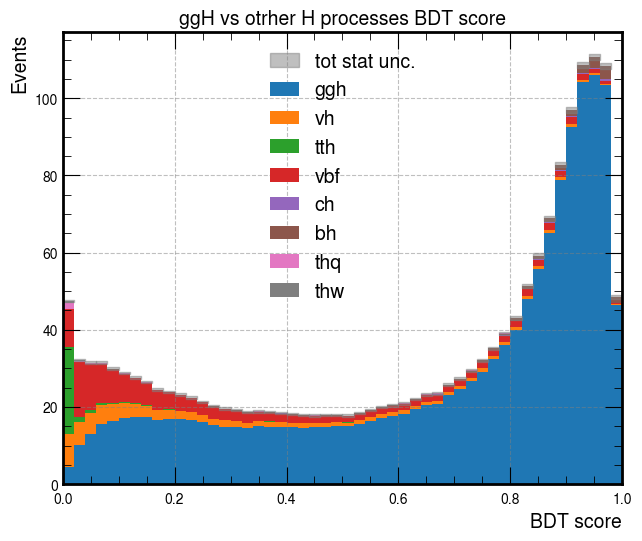

In [19]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 6))

title = "ggH vs otrher H processes BDT score"
var = "ggh_vs_hb_bdt_sig_score"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["thw", "thq", "bh", "ch", "vbf", "tth", "vh",  "ggh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            full_hist.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["weight_norm"], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["square_weight"], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["weight_norm"], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["square_weight"], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()

ax0.set_xlim([min_, max_])
ax0.set_xlabel('BDT score', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()

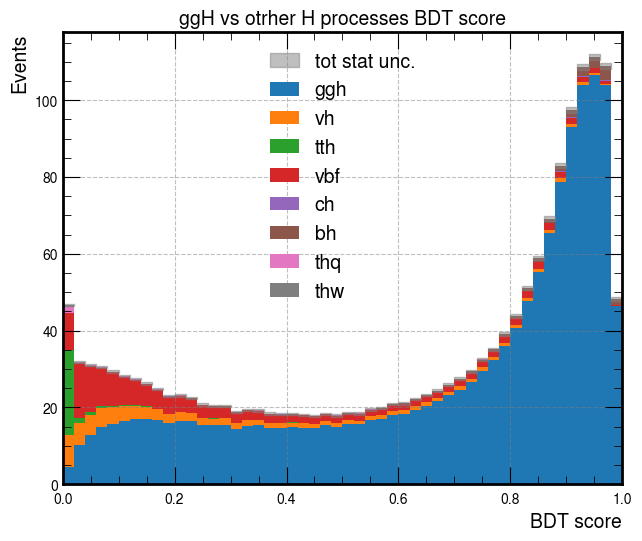

In [20]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 6))

title = "ggH vs otrher H processes BDT score"
var = "mva_score_sig"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["thw", "thq", "bh", "ch", "vbf", "tth", "vh",  "ggh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            full_hist.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["weight_norm"], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["square_weight"], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["weight_norm"], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["square_weight"], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()

ax0.set_xlim([min_, max_])
ax0.set_xlabel('BDT score', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()

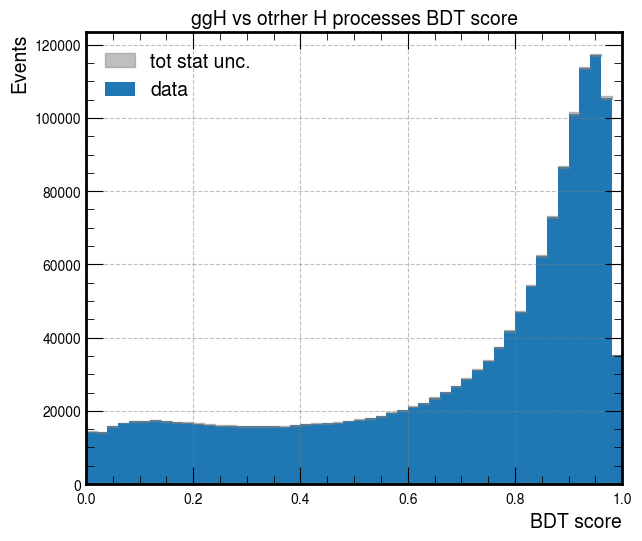

In [21]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 6))

title = "ggH vs otrher H processes BDT score"
var = "ggh_vs_hb_bdt_sig_score"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["data"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)


for cat in cats:
    if len(fileset_data[cat].weight) > 1:
        full_hist.fill(ax = fileset_data[cat][var], weight = fileset_data[cat]["weight"], c="data")
        full_hist_err.fill(ax = fileset_data[cat][var], weight = fileset_data[cat]["weight"], c="data")
        tot_hist.fill(ax = fileset_data[cat][var], weight = fileset_data[cat]["weight"], c="tot")
        tot_hist_err.fill(ax = fileset_data[cat][var], weight = fileset_data[cat]["weight"], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()

ax0.set_xlim([min_, max_])
ax0.set_xlabel('BDT score', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()

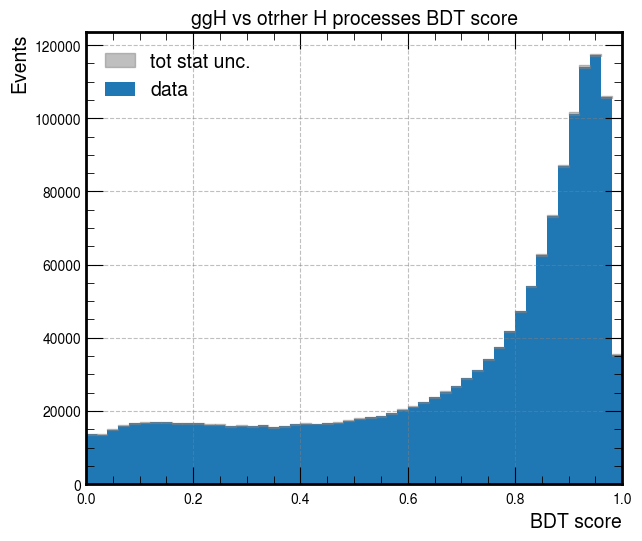

In [22]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 6))

title = "ggH vs otrher H processes BDT score"
var = "mva_score_sig"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["data"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)


for cat in cats:
    if len(fileset_data[cat].weight) > 1:
        full_hist.fill(ax = fileset_data[cat][var], weight = fileset_data[cat]["weight"], c="data")
        full_hist_err.fill(ax = fileset_data[cat][var], weight = fileset_data[cat]["weight"], c="data")
        tot_hist.fill(ax = fileset_data[cat][var], weight = fileset_data[cat]["weight"], c="tot")
        tot_hist_err.fill(ax = fileset_data[cat][var], weight = fileset_data[cat]["weight"], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()

ax0.set_xlim([min_, max_])
ax0.set_xlabel('BDT score', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()

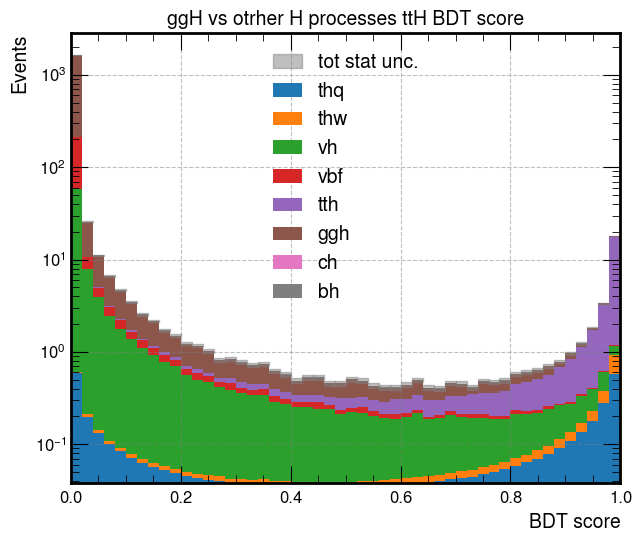

In [23]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 6))

title = "ggH vs otrher H processes ttH BDT score"
if not MULTICLASS:
    var = "ggh_vs_hb_bdt_score"
else:
    var = "ggh_vs_hb_bdt_tth_score"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["bh", "ch",  "ggh", "tth",   "vbf", "vh",  "thw", "thq"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            filter = (
                fileset[sample][cat]["bdt_score"] > 0.
            )
            full_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
ax0.set_yscale('log')
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()

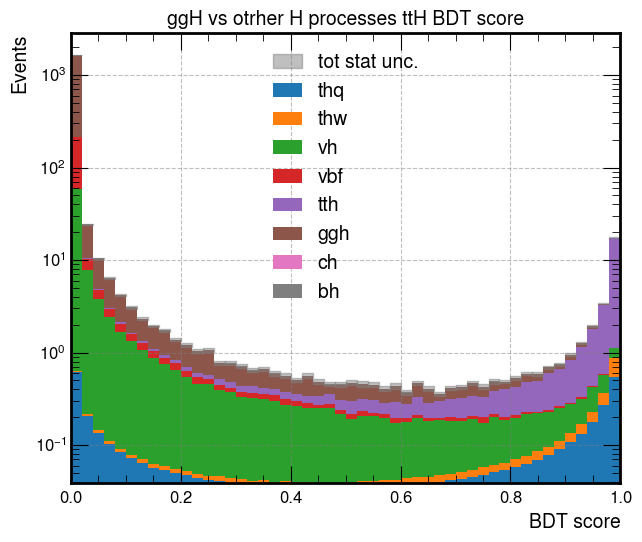

In [24]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 6))

title = "ggH vs otrher H processes ttH BDT score"
var = "mva_score_tth"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["bh", "ch",  "ggh", "tth",   "vbf", "vh",  "thw", "thq",], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            full_hist.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["weight_norm"], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["square_weight"], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["weight_norm"], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["square_weight"], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()

ax0.set_xlim([min_, max_])
ax0.set_yscale('log')
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()

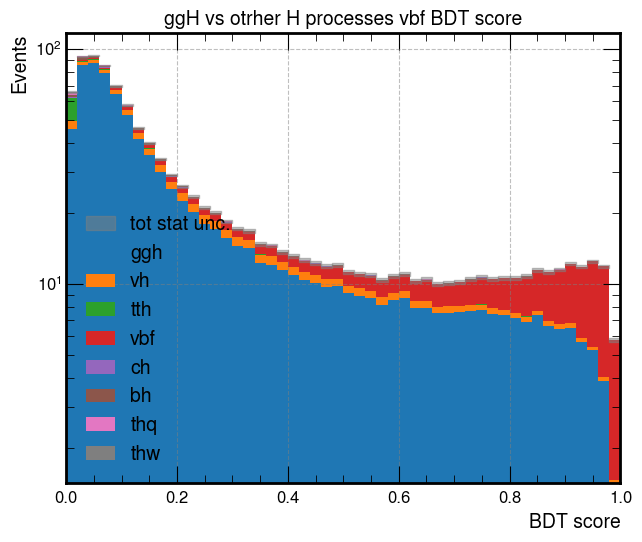

In [25]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 6))

title = "ggH vs otrher H processes vbf BDT score"
if not MULTICLASS:
    var = "ggh_vs_hb_bdt_score"
else:
    var = "ggh_vs_hb_bdt_vbf_score"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["thw", "thq", "bh", "ch", "vbf", "tth", "vh",  "ggh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            filter = (
                fileset[sample][cat]["bdt_score"] > 0.8
            )
            full_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
ax0.set_yscale('log')
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()

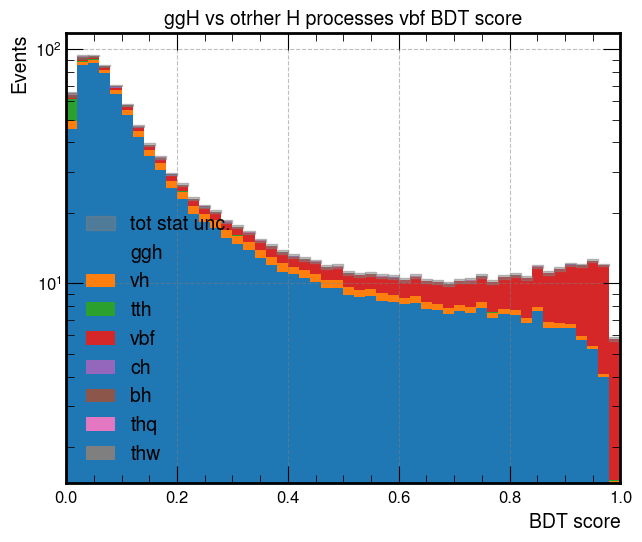

In [26]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 6))

title = "ggH vs otrher H processes vbf BDT score"
var = "mva_score_vbf"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["thw", "thq", "bh", "ch", "vbf", "tth", "vh",  "ggh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            filter = (
                fileset[sample][cat]["bdt_score"] > 0.8
            )
            full_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
ax0.set_yscale('log')
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()

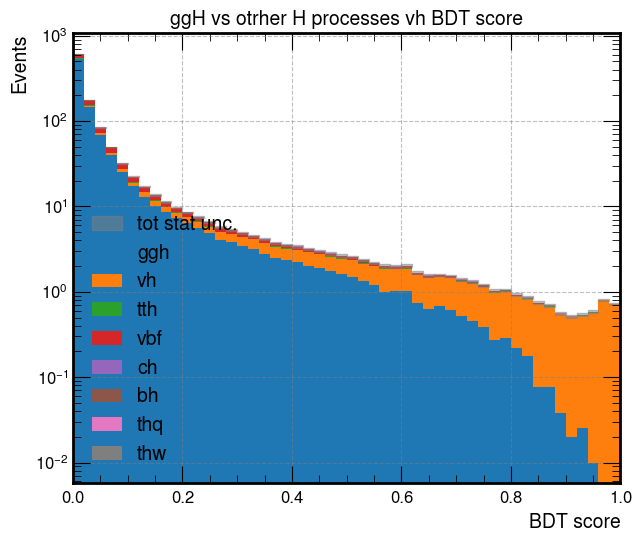

In [27]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 6))

title = "ggH vs otrher H processes vh BDT score"
var = "ggh_vs_hb_bdt_vh_score"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["thw", "thq", "bh", "ch", "vbf", "tth", "vh",  "ggh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            filter = (
                fileset[sample][cat]["bdt_score"] > 0.8
            )
            full_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
ax0.set_yscale('log')
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()

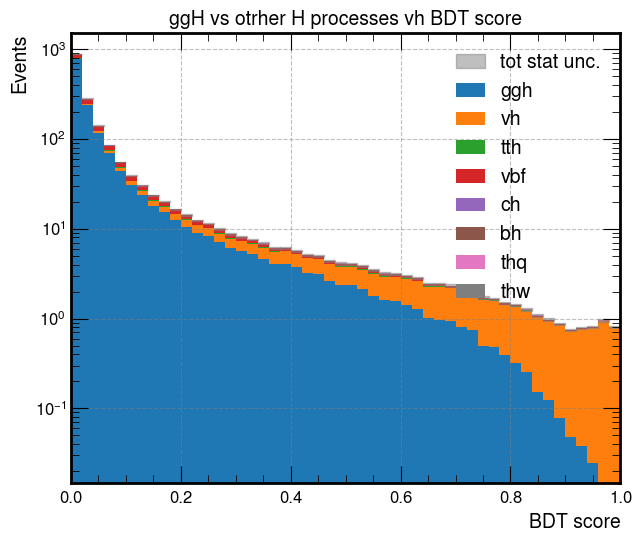

In [28]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 6))

title = "ggH vs otrher H processes vh BDT score"
var = "mva_score_vh"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["thw", "thq", "bh", "ch", "vbf", "tth", "vh",  "ggh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            filter = (
                fileset[sample][cat]["bdt_score"] > 0.
            )
            full_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
ax0.set_yscale('log')
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()

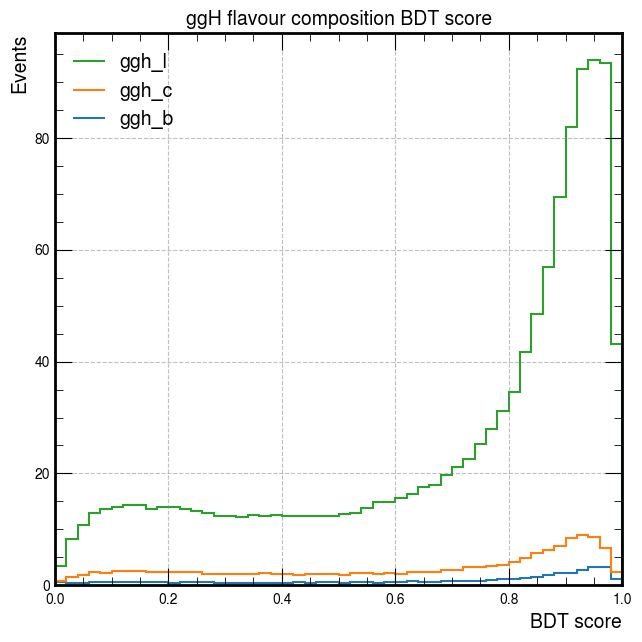

In [29]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 7))

title = "ggH flavour composition BDT score"
var = "ggh_vs_hb_bdt_sig_score"
min_ = 0.
max_ = 1
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh"], name="c")
LeadPhoton_et_cax_flav = hist.axis.StrCategory(["ggh_l", "ggh_c", "ggh_b"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_flav = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_flav)
full_hist_flav_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_flav)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            full_hist.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["weight_norm"], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["square_weight"], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["weight_norm"], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["square_weight"], c="tot")
            if "ggh" in sample:
                for flavour in ["_l", "_c", "_b"]:
                    if "_l" in flavour:
                        lab = "ggh_l"
                        mask = (~fileset[sample][cat]["bottom_flag_gen"]) & (~fileset[sample][cat]["charmed_flag_gen"])
                    elif "_c" in flavour:
                        lab = "ggh_c"
                        mask = (~fileset[sample][cat]["bottom_flag_gen"]) & (fileset[sample][cat]["charmed_flag_gen"])
                    else:
                        lab = "ggh_b"
                        mask = (fileset[sample][cat]["bottom_flag_gen"])
                    full_hist_flav.fill(ax = fileset[sample][cat][var][mask], weight = fileset[sample][cat]["weight_norm"][mask], c=lab)
                    full_hist_flav_err.fill(ax = fileset[sample][cat][var][mask], weight = fileset[sample][cat]["square_weight"][mask], c=lab)
            else:
                full_hist_flav.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["weight_norm"], c="other")
                full_hist_flav_err.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["square_weight"], c="other")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")
h_stack_flav = full_hist_flav.stack("c")
h_stack_err_flav = full_hist_flav_err.stack("c")

stack = False
#h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
h_stack_flav[::-1].plot(ax=ax0, stack=stack, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)
plt.tight_layout()
    
plt.plot()
plt.show()

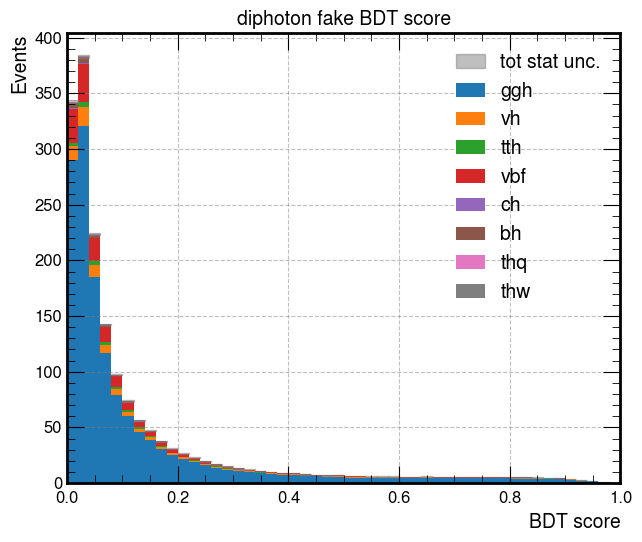

In [30]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 6))

title = "diphoton fake BDT score"
var = "diph_bdt_fk_score"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["thw", "thq", "bh", "ch", "vbf", "tth", "vh",  "ggh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            filter = (
                fileset[sample][cat]["bdt_score"] > 0.
            )
            full_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
#ax0.set_yscale('log')
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()

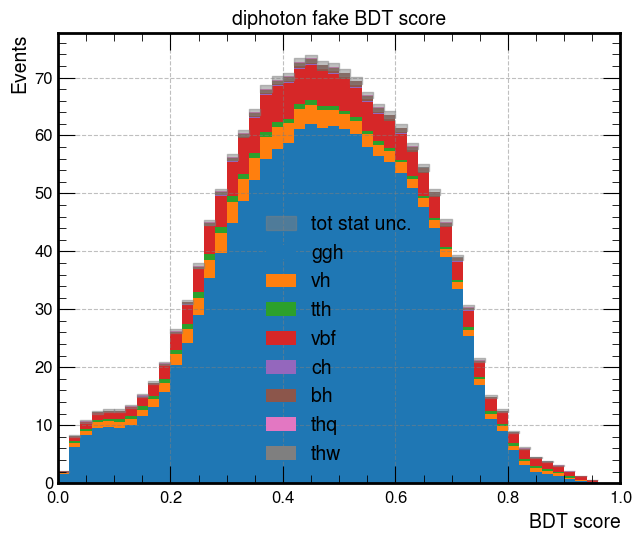

In [31]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 6))

title = "diphoton fake BDT score"
var = "diph_bdt_sig_score"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["thw", "thq", "bh", "ch", "vbf", "tth", "vh",  "ggh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            filter = (
                fileset[sample][cat]["bdt_score"] > 0.
            )
            full_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
#ax0.set_yscale('log')
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()

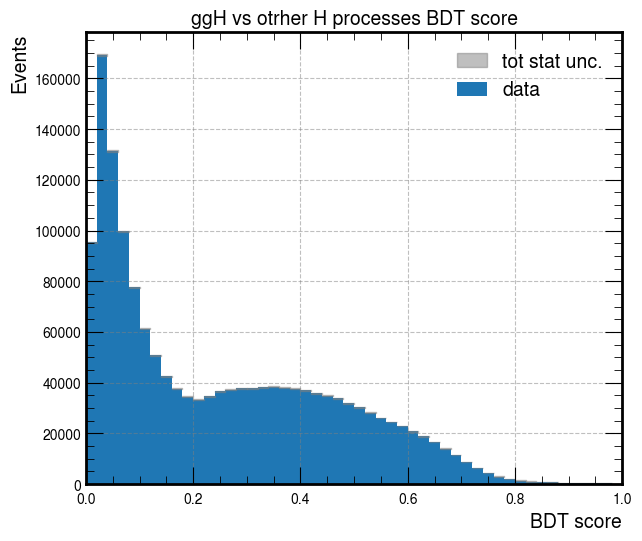

In [32]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 6))

title = "ggH vs otrher H processes BDT score"
var = "diph_bdt_ph_score"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["data"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)


for cat in cats:
    if len(fileset_data[cat].weight) > 1:
        full_hist.fill(ax = fileset_data[cat][var], weight = fileset_data[cat]["weight"], c="data")
        full_hist_err.fill(ax = fileset_data[cat][var], weight = fileset_data[cat]["weight"], c="data")
        tot_hist.fill(ax = fileset_data[cat][var], weight = fileset_data[cat]["weight"], c="tot")
        tot_hist_err.fill(ax = fileset_data[cat][var], weight = fileset_data[cat]["weight"], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()

ax0.set_xlim([min_, max_])
ax0.set_xlabel('BDT score', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()

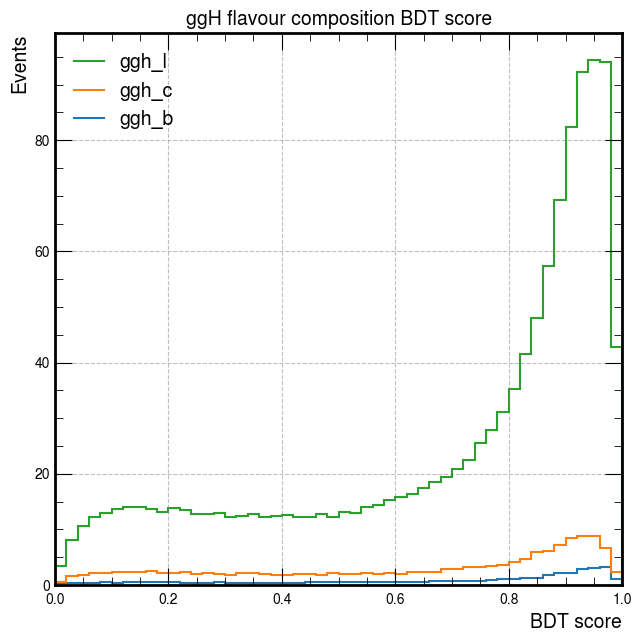

In [33]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 7))

title = "ggH flavour composition BDT score"
var = "mva_score_sig"
min_ = 0.
max_ = 1
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh"], name="c")
LeadPhoton_et_cax_flav = hist.axis.StrCategory(["ggh_l", "ggh_c", "ggh_b"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_flav = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_flav)
full_hist_flav_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_flav)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            full_hist.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["weight_norm"], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["square_weight"], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["weight_norm"], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["square_weight"], c="tot")
            if "ggh" in sample:
                for flavour in ["_l", "_c", "_b"]:
                    if "_l" in flavour:
                        lab = "ggh_l"
                        mask = (~fileset[sample][cat]["bottom_flag_gen"]) & (~fileset[sample][cat]["charmed_flag_gen"])
                    elif "_c" in flavour:
                        lab = "ggh_c"
                        mask = (~fileset[sample][cat]["bottom_flag_gen"]) & (fileset[sample][cat]["charmed_flag_gen"])
                    else:
                        lab = "ggh_b"
                        mask = (fileset[sample][cat]["bottom_flag_gen"])
                    full_hist_flav.fill(ax = fileset[sample][cat][var][mask], weight = fileset[sample][cat]["weight_norm"][mask], c=lab)
                    full_hist_flav_err.fill(ax = fileset[sample][cat][var][mask], weight = fileset[sample][cat]["square_weight"][mask], c=lab)
            else:
                full_hist_flav.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["weight_norm"], c="other")
                full_hist_flav_err.fill(ax = fileset[sample][cat][var], weight = fileset[sample][cat]["square_weight"], c="other")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")
h_stack_flav = full_hist_flav.stack("c")
h_stack_err_flav = full_hist_flav_err.stack("c")

stack = False
#h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
h_stack_flav[::-1].plot(ax=ax0, stack=stack, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)
plt.tight_layout()
    
plt.plot()
plt.show()

# Settings

In [34]:
dipho = 0.76
dipho_fake = 0.15
dipho_sig = 0.1
rb_sig = 0.79
rb_bkg = 0.9
tth_bkg = 0.9
vh_bkg = 0.9
# first_jet_jet_pn_b_vs_c = 0.4
first_jet_jet_pn_b_vs_c = 0.7
mva_sig = "mva_score_sig"
mva_tth = "mva_score_tth"
mva_vbf = "mva_score_vbf"
mva_vh = "mva_score_vh"
dipho_multiclass = False

In [35]:
dir_ext = f'HpC_signal_newBDT_250804_d0p{str(dipho).split(".")[-1]}_sig0p{str(rb_sig).split(".")[-1]}_bkg0p{str(rb_bkg).split(".")[-1]}_{year}_WP51'

In [36]:
cat_dict = {
    "bTag_high": {
        "cat_filter": [
            ["n_jets", ">", 0],
            ["first_jet_jet_pn_b_plus_c", ">", 0.5],
            ["first_jet_jet_pn_b_vs_c", ">", first_jet_jet_pn_b_vs_c],
            ["bdt_score", ">", dipho],
            [mva_sig, ">", rb_sig],
            [mva_tth, "<=", tth_bkg],
            [mva_vbf, "<=", rb_bkg],
            [mva_vh, "<=", vh_bkg],
            ["CMS_hgg_mass", ">", 100],
            ["CMS_hgg_mass", "<", 180]
        ]
    },
    "bTag_low": {
        "cat_filter": [
            ["n_jets", ">", 0],
            ["first_jet_jet_pn_b_plus_c", ">", 0.5],
            ["first_jet_jet_pn_b_vs_c", ">", first_jet_jet_pn_b_vs_c],
            ["bdt_score", ">", dipho],
            [mva_sig, "<=", rb_sig],
            [mva_tth, "<=", tth_bkg],
            [mva_vbf, "<=", rb_bkg],
            [mva_vh, "<=", vh_bkg],
            ["CMS_hgg_mass", ">", 100],
            ["CMS_hgg_mass", "<", 180]
        ]
    },
    "cTag_high": {
        "cat_filter": [
            ["n_jets", ">", 0],
            ["first_jet_jet_pn_b_plus_c", ">", 0.5],
            ["first_jet_jet_pn_b_vs_c", "<=", first_jet_jet_pn_b_vs_c],
            ["bdt_score", ">", dipho],
            [mva_sig, ">", rb_sig],
            [mva_tth, "<=", tth_bkg],
            [mva_vbf, "<=", rb_bkg],
            [mva_vh, "<=", vh_bkg],
            ["CMS_hgg_mass", ">", 100],
            ["CMS_hgg_mass", "<", 180]
        ]
    },
    "cTag_low": {
        "cat_filter": [
            ["n_jets", ">", 0],
            ["first_jet_jet_pn_b_plus_c", ">", 0.5],
            ["first_jet_jet_pn_b_vs_c", "<=", first_jet_jet_pn_b_vs_c],
            ["bdt_score", ">", dipho],
            [mva_sig, "<=", rb_sig],
            [mva_tth, "<=", tth_bkg],
            [mva_vbf, "<=", rb_bkg],
            [mva_vh, "<=", vh_bkg],
            ["CMS_hgg_mass", ">", 100],
            ["CMS_hgg_mass", "<", 180]
        ]
    },
    "lTag_high": {
        "cat_filter": [
            ["n_jets", ">", 0],
            ["first_jet_jet_pn_b_plus_c", "<=", 0.5],
            ["bdt_score", ">", dipho],
            [mva_sig, ">", rb_sig],
            [mva_tth, "<=", rb_bkg],
            [mva_vbf, "<=", rb_bkg],
            [mva_vh, "<=", vh_bkg],
            ["CMS_hgg_mass", ">", 100],
            ["CMS_hgg_mass", "<", 180]
        ]
    },
    "lTag_low": {
        "cat_filter": [
            ["n_jets", ">", 0],
            ["first_jet_jet_pn_b_plus_c", "<=", 0.5],
            ["bdt_score", ">", dipho],
            [mva_sig, "<=", rb_sig],
            [mva_tth, "<=", tth_bkg],
            [mva_vbf, "<=", rb_bkg],
            [mva_vh, "<=", vh_bkg],
            ["CMS_hgg_mass", ">", 100],
            ["CMS_hgg_mass", "<", 180]
        ]
    },
    "tthTag": {
        "cat_filter": [
            ["n_jets", ">", 0],
            ["first_jet_jet_pn_b_plus_c", ">", 0.5],
            ["bdt_score", ">", dipho],
            [mva_tth, ">", tth_bkg],
            [mva_vbf, "<=", rb_bkg],
            [mva_vh, "<=", vh_bkg],
            ["CMS_hgg_mass", ">", 100],
            ["CMS_hgg_mass", "<", 180]
        ]
    },
    "vbfTag": {
        "cat_filter": [
            ["n_jets", ">", 0],
            ["bdt_score", ">", dipho],
            [mva_tth, "<=", tth_bkg],
            [mva_vbf, ">", rb_bkg],
            [mva_vh, "<=", vh_bkg],
            ["CMS_hgg_mass", ">", 100],
            ["CMS_hgg_mass", "<", 180]
        ]
    },
    "vhTag": {
        "cat_filter": [
            ["n_jets", ">", 0],
            ["bdt_score", ">", dipho],
            [mva_tth, "<=", tth_bkg],
            [mva_vbf, "<=", rb_bkg],
            [mva_vh, ">", vh_bkg],
            ["CMS_hgg_mass", ">", 100],
            ["CMS_hgg_mass", "<", 180]
        ]
    }
}

In [37]:
if dipho_multiclass:
    dir_ext = f'HpC_signal_newBDT_250430_df0p{str(dipho_fake).split(".")[-1]}_ds0p{str(dipho_sig).split(".")[-1]}_sig0p{str(rb_sig).split(".")[-1]}_bkg0p{str(rb_bkg).split(".")[-1]}'
    cat_dict = {
        "bTag_high": {
            "cat_filter": [
                ["n_jets", ">", 0],
                ["first_jet_jet_pn_b_plus_c", ">", 0.5],
                ["first_jet_jet_pn_b_vs_c", ">", 0.7],
                ["diph_bdt_ph_score", "<", dipho_fake],
                ["diph_bdt_sig_score", ">", dipho_sig],
                [mva_sig, ">", rb_sig],
                [mva_tth, "<=", tth_bkg],
                [mva_vbf, "<=", rb_bkg],
                [mva_vh, "<=", rb_bkg],
                ["CMS_hgg_mass", ">", 100],
                ["CMS_hgg_mass", "<", 180]
            ]
        },
        "bTag_low": {
            "cat_filter": [
                ["n_jets", ">", 0],
                ["first_jet_jet_pn_b_plus_c", ">", 0.5],
                ["first_jet_jet_pn_b_vs_c", ">", 0.7],
                ["diph_bdt_ph_score", "<", dipho_fake],
                ["diph_bdt_sig_score", ">", dipho_sig],
                [mva_sig, "<=", rb_sig],
                [mva_tth, "<=", tth_bkg],
                [mva_vbf, "<=", rb_bkg],
                [mva_vh, "<=", rb_bkg],
                ["CMS_hgg_mass", ">", 100],
                ["CMS_hgg_mass", "<", 180]
            ]
        },
        "cTag_high": {
            "cat_filter": [
                ["n_jets", ">", 0],
                ["first_jet_jet_pn_b_plus_c", ">", 0.5],
                ["first_jet_jet_pn_b_vs_c", "<=", 0.7],
                ["diph_bdt_ph_score", "<", dipho_fake],
                ["diph_bdt_sig_score", ">", dipho_sig],
                [mva_sig, ">", rb_sig],
                [mva_tth, "<=", tth_bkg],
                [mva_vbf, "<=", rb_bkg],
                [mva_vh, "<=", rb_bkg],
                ["CMS_hgg_mass", ">", 100],
                ["CMS_hgg_mass", "<", 180]
            ]
        },
        "cTag_low": {
            "cat_filter": [
                ["n_jets", ">", 0],
                ["first_jet_jet_pn_b_plus_c", ">", 0.5],
                ["first_jet_jet_pn_b_vs_c", "<=", 0.7],
                ["diph_bdt_ph_score", "<", dipho_fake],
                ["diph_bdt_sig_score", ">", dipho_sig],
                [mva_sig, "<=", rb_sig],
                [mva_tth, "<=", tth_bkg],
                [mva_vbf, "<=", rb_bkg],
                [mva_vh, "<=", rb_bkg],
                ["CMS_hgg_mass", ">", 100],
                ["CMS_hgg_mass", "<", 180]
            ]
        },
        "lTag_high": {
            "cat_filter": [
                ["n_jets", ">", 0],
                ["first_jet_jet_pn_b_plus_c", "<=", 0.5],
                ["diph_bdt_ph_score", "<", dipho_fake],
                ["diph_bdt_sig_score", ">", dipho_sig],
                [mva_sig, ">", rb_sig],
                [mva_tth, "<=", rb_bkg],
                [mva_vbf, "<=", rb_bkg],
                [mva_vh, "<=", rb_bkg],
                ["CMS_hgg_mass", ">", 100],
                ["CMS_hgg_mass", "<", 180]
            ]
        },
        "lTag_low": {
            "cat_filter": [
                ["n_jets", ">", 0],
                ["first_jet_jet_pn_b_plus_c", "<=", 0.5],
                ["diph_bdt_ph_score", "<", dipho_fake],
                ["diph_bdt_sig_score", ">", dipho_sig],
                [mva_sig, "<=", rb_sig],
                [mva_tth, "<=", tth_bkg],
                [mva_vbf, "<=", rb_bkg],
                [mva_vh, "<=", rb_bkg],
                ["CMS_hgg_mass", ">", 100],
                ["CMS_hgg_mass", "<", 180]
            ]
        },
        "tthTag": {
            "cat_filter": [
                ["n_jets", ">", 0],
                ["first_jet_jet_pn_b_plus_c", ">", 0.5],
                ["diph_bdt_ph_score", "<", dipho_fake],
                ["diph_bdt_sig_score", ">", dipho_sig],
                [mva_tth, ">", tth_bkg],
                [mva_vbf, "<=", rb_bkg],
                [mva_vh, "<=", rb_bkg],
                ["CMS_hgg_mass", ">", 100],
                ["CMS_hgg_mass", "<", 180]
            ]
        },
        "vbfTag": {
            "cat_filter": [
                ["n_jets", ">", 0],
                ["diph_bdt_ph_score", "<", dipho_fake],
                ["diph_bdt_sig_score", ">", dipho_sig],
                [mva_tth, "<=", tth_bkg],
                [mva_vbf, ">", rb_bkg],
                [mva_vh, "<=", rb_bkg],
                ["CMS_hgg_mass", ">", 100],
                ["CMS_hgg_mass", "<", 180]
            ]
        },
        "vhTag": {
            "cat_filter": [
                ["n_jets", ">", 0],
                ["diph_bdt_ph_score", "<", dipho_fake],
                ["diph_bdt_sig_score", ">", dipho_sig],
                [mva_tth, "<=", tth_bkg],
                [mva_vbf, "<=", rb_bkg],
                [mva_vh, ">", rb_bkg],
                ["CMS_hgg_mass", ">", 100],
                ["CMS_hgg_mass", "<", 180]
            ]
        }
    }

In [38]:
yields_cats = {
    "ggh_l" : 0,
    "ggh_b" : 0,
    "ggh_c" : 0,
    "bh" : 0,
    "ch" : 0,
    "vbf" : 0,
    "tth" : 0,
    "vh" : 0,
    "thw" : 0,
    "thq" : 0
}


In [39]:
ordered_samples = [
    f'ggh_M125_{year}',
    f'bH_5FS_FXFX_M125_{year}',
    f'cH_4FS_FXFX_M125_{year}',
    f'vbf_M125_{year}',
    f'tth_M125_{year}',
    f'vh_M125_{year}',
    f'THQ_HToGG_{year}',
    f'THW_HToGG_{year}'
]

saving plot: yields_250821_no_cats_HpC_signal_newBDT_250804_d0p76_sig0p79_bkg0p9_2018_WP51.png


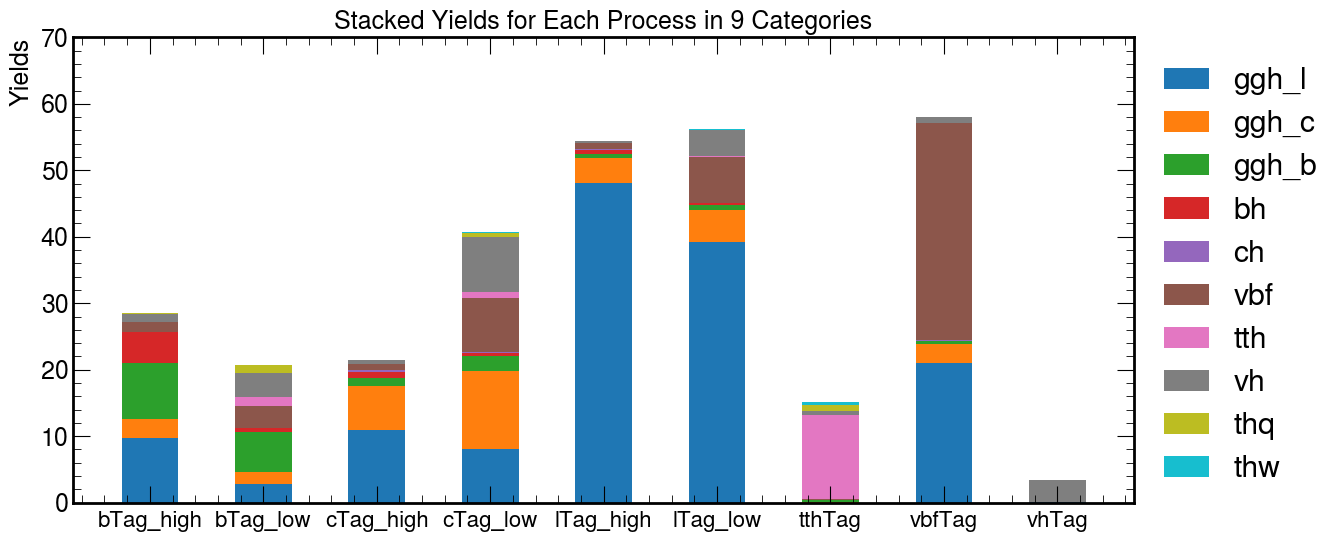

In [40]:
# Number of categories, processes, and yields
n_categories = len([*cat_dict])
n_processes = len([*yields_cats])

# Category labels
categories = [*cat_dict]
samples_ = ["ggh", "bh", "ch", "vbf", "tth", "vh", "thw", "thq"]

yields = {}

# X positions for the categories
x = np.arange(n_categories)

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Initialize the bottom values for each category (to stack yields)
bottoms = np.zeros(n_categories)
tot_categories = np.zeros(n_categories)

# Loop over the processes and create stacked bars for each category
for sample in ordered_samples:
    # Stack the 3 yields for each process
    proc = sample.split("_")[0].lower()
    if proc == "ggh":
        for flavour in ["l", "c", "b"]:
            if "l" in flavour:
                lab = "ggh_l"
                mask = (~fileset[sample]["NOTAG"]["bottom_flag_gen"]) & (~fileset[sample]["NOTAG"]["charmed_flag_gen"])
            elif "c" in flavour:
                lab = "ggh_c"
                mask = (~fileset[sample]["NOTAG"]["bottom_flag_gen"]) & (fileset[sample]["NOTAG"]["charmed_flag_gen"])
            else:
                lab = "ggh_b"
                mask = (fileset[sample]["NOTAG"]["bottom_flag_gen"])
            sum_ = []
            yields[lab] = {}
            events = fileset[sample]["NOTAG"][mask]
            for cat in cat_dict:
                integral = calculate_yields(events, cat_dict[cat])
                yields[lab][cat] = integral
                if ("lT" in cat):
                    sum_.append(integral/10)
                else:
                    sum_.append(integral)
            ax.bar(
                x,                      # Same x positions for all processes
                sum_,                    # Sum of yields for the current process
                width=0.5,               # Bar width for better visibility
                bottom=bottoms,          # Start from the accumulated yields
                label=lab               # Label for each process
            )
            # Update bottoms for stacking
            bottoms += sum_
    else:
        yields[proc] = {}
        sum_ = []
        events = fileset[sample]["NOTAG"]
        for cat in cat_dict:
            integral = calculate_yields(events, cat_dict[cat])
            yields[proc][cat] = integral
            if ("lT" in cat):
                sum_.append(integral/10)
            else:
                sum_.append(integral)
        ax.bar(
            x,                      # Same x positions for all processes
            sum_,                    # Sum of yields for the current process
            width=0.5,               # Bar width for better visibility
            bottom=bottoms,          # Start from the accumulated yields
            label=proc               # Label for each process
        )
        # Update bottoms for stacking
        bottoms += sum_

# Add category labels
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=16)
ax.set_ylim([0, 70])
ax.set_ylabel('Yields', fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_title(f'Stacked Yields for Each Process in {n_categories} Categories', fontsize=18)

# ax.set_yscale('log')

# Create a legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()

print(f"saving plot: yields_{ext}_{dir_ext}.png")
plt.savefig(f"yields_{ext}_{dir_ext}.png")
plt.show()

In [41]:
print(f"yields_{ext}_{dir_ext}.png")

yields_250821_no_cats_HpC_signal_newBDT_250804_d0p76_sig0p79_bkg0p9_2018_WP51.png


Fit successful: [ 7.66938968e+03 -4.09294125e-02]
Fit successful: [ 2.86728346e+03 -3.62596988e-02]
Fit successful: [ 2.48972117e+04 -3.95987809e-02]
Fit successful: [ 3.69576794e+04 -4.13169936e-02]
Fit successful: [ 3.34761649e+05 -4.36571995e-02]
Fit successful: [ 1.62819566e+05 -3.89694229e-02]
Fit successful: [ 1.94583240e+03 -4.44183013e-02]
Fit successful: [ 1.70332988e+03 -3.06866546e-02]
Fit successful: [0.05261633 0.0337479 ]


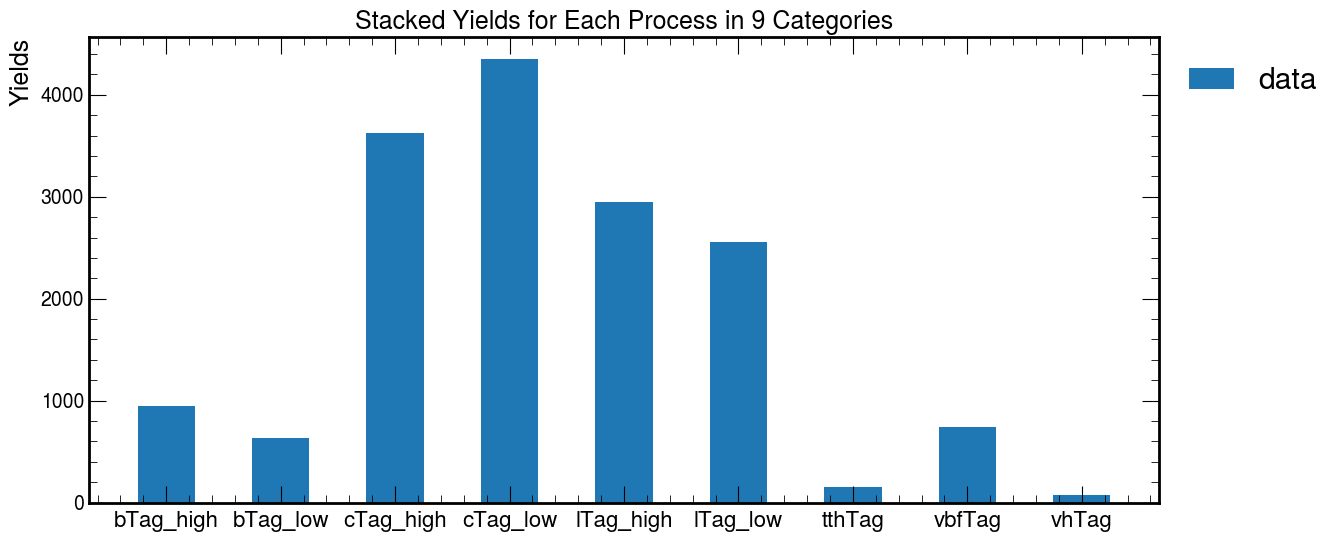

In [42]:
# Number of categories, processes, and yields
n_categories = len([*cat_dict])
n_processes = len([*yields_cats])


# Category labels
categories = [*cat_dict]
samples_ = ["data"]

# X positions for the categories
x = np.arange(n_categories)

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Initialize the bottom values for each category (to stack yields)
bottoms = np.zeros(n_categories)
tot_categories = np.zeros(n_categories)

# Loop over the processes and create stacked bars for each category
for proc in samples_:
    yields[proc] = {}
    sum_ = []
    events = fileset_data["NOTAG"]
    for cat in cat_dict:
        integral = calculate_yields_data(events, cat_dict[cat])
        yields[proc][cat] = integral
        if ("lT" in cat):
            sum_.append(integral/10)
        else:
            sum_.append(integral)
    ax.bar(
        x,                      # Same x positions for all processes
        sum_,                    # Sum of yields for the current process
        width=0.5,               # Bar width for better visibility
        bottom=bottoms,          # Start from the accumulated yields
        label=proc               # Label for each process
    )
    # Update bottoms for stacking
    bottoms += sum_

# Add category labels
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=16)

# Add labels and title
#ax.set_xlabel('Categories', fontsize=18)
#ax.set_ylim([0, 50])
ax.set_ylabel('Yields', fontsize=18)
ax.tick_params(axis='y', labelsize=14)
ax.set_title(f'Stacked Yields for Each Process in {n_categories} Categories', fontsize=18)

# ax.set_yscale('log')

# Create a legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()

plt.savefig(f"yields_data_{ext}_{dir_ext}.png")
plt.show()

Category: bTag_high
    * ggh_b
    * ggh_c
    * ggh_l
    * bh
    * ch
    * vbf
    * tth
    * vh
    * thw
    * thq
    * data
13.073313383355476 961.4628612988561
Category: bTag_low
    * ggh_b
    * ggh_c
    * ggh_l
    * bh
    * ch
    * vbf
    * tth
    * vh
    * thw
    * thq
    * data
6.729519699244628 644.3448895879437
Category: cTag_high
    * ggh_b
    * ggh_c
    * ggh_l
    * bh
    * ch
    * vbf
    * tth
    * vh
    * thw
    * thq
    * data
6.692783083856189 3635.4213824984818
Category: cTag_low
    * ggh_b
    * ggh_c
    * ggh_l
    * bh
    * ch
    * vbf
    * tth
    * vh
    * thw
    * thq
    * data
11.882718524716207 4374.431325564274
Category: lTag_high
    * ggh_b
    * ggh_c
    * ggh_l
    * bh
    * ch
    * vbf
    * tth
    * vh
    * thw
    * thq
    * data
480.61164908390975 29539.24167595838
Category: lTag_low
    * ggh_b
    * ggh_c
    * ggh_l
    * bh
    * ch
    * vbf
    * tth
    * vh
    * thw
    * thq
    * data
392.48729419540

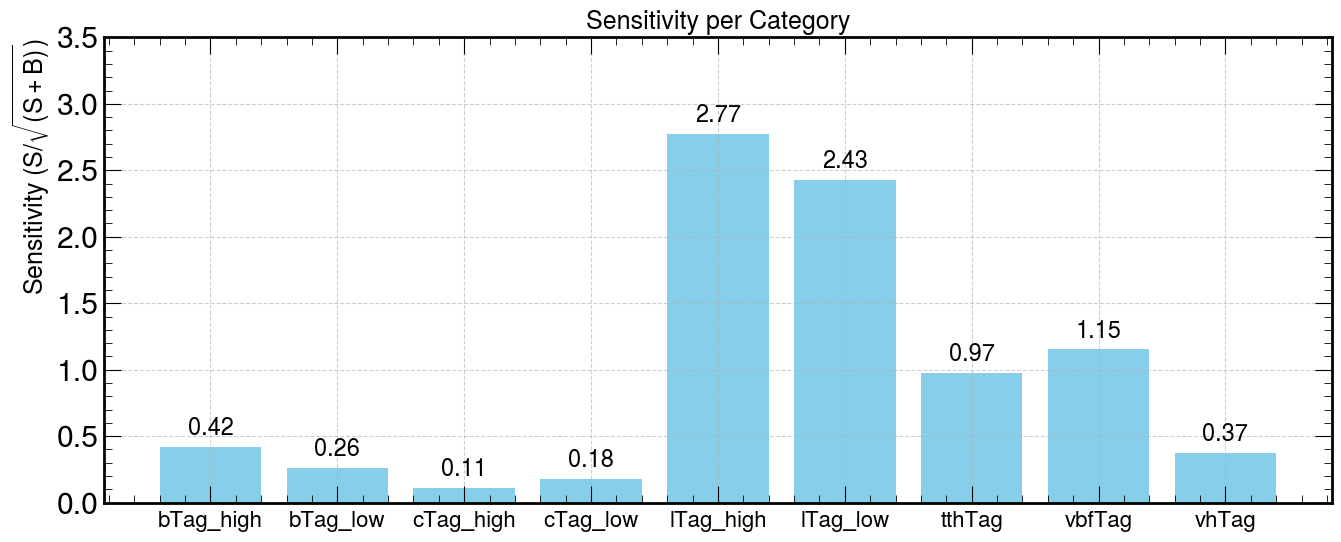

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Number of categories, processes, and yields
n_categories = len([*cat_dict])
n_processes = len([*yields_cats])

# Category labels
categories = [*cat_dict]
samples_ = ["ggh_b", "ggh_c", "ggh_l", "bh", "ch", "vbf", "tth", "vh", "thw", "thq", "data"]

# X positions for the categories
x = np.arange(n_categories)

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Initialize the bottom values for each category (to stack yields)
bottoms = np.zeros(n_categories)
tot_categories = np.zeros(n_categories)

# List to store sensitivity values
sensitivities = []

# Loop over the categories
for i, cat in enumerate(categories):
    S = 0
    B = 0
    print("Category:", cat)
    for sample in samples_:
        if sample == "ggh":
            continue
        print("    *", sample)
        if "bTag" in cat:
            if sample in ["ggh_b", "bh"]:
                S += yields[sample][cat]
            else:
                B += yields[sample][cat]
        elif "cTag" in cat:
            if sample in ["ggh_c", "ch"]:
                S += yields[sample][cat]
            else:
                B += yields[sample][cat]
        elif "lTag" in cat:
            if sample in ["ggh_l"]:
                S += yields[sample][cat]
            else:
                B += yields[sample][cat]
        elif "tthTag" in cat:
            if sample in ["tth"]:
                S += yields[sample][cat]
            else:
                B += yields[sample][cat]
        elif "vbfTag" in cat:
            if sample in ["vbf"]:
                S += yields[sample][cat]
            else:
                B += yields[sample][cat]
        elif "vhTag" in cat:
            if sample in ["vh"]:
                S += yields[sample][cat]
            else:
                B += yields[sample][cat]
    # Compute and store sensitivity
    print(S, B)
    sensitivity = S / np.sqrt(S + B) if S + B > 0 else 0
    sensitivities.append(sensitivity)

ax.bar(x, sensitivities, color='skyblue')
# Annotate bars with sensitivity values
for i, sens in enumerate(sensitivities):
    ax.text(x[i], sens + 0.05, f"{sens:.2f}", ha='center', va='bottom', fontsize=17)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=0, ha='center', fontsize=16)
ax.set_ylabel("Sensitivity ($S/\sqrt{(S+B)}$)", fontsize=18)
ax.set_title("Sensitivity per Category", fontsize=18)
ax.set_ylim([0, 3.5])
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f"sensitivity_{ext}_{dir_ext}.png")
plt.show()


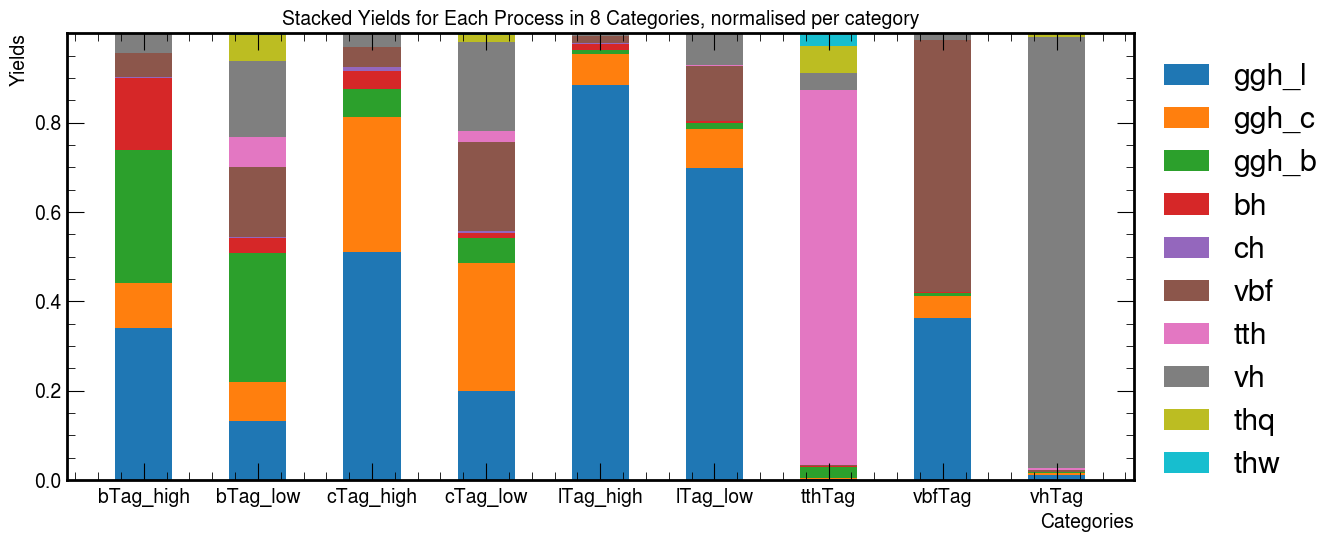

In [44]:
# Number of categories, processes, and yields
n_categories = len([*cat_dict])
n_processes = len([*yields_cats])

# Category labels
categories = [*cat_dict]
samples_ = ["ggh", "bh", "ch", "vbf", "tth", "vh", "thw", "thq"]

# X positions for the categories
x = np.arange(n_categories)

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Initialize the bottom values for each category (to stack yields)
bottoms = np.zeros(n_categories)
tot_categories = np.zeros(n_categories)

for cat in cat_dict:
    cat_dict[cat]["yields_tot"] = 0.

for sample in ordered_samples:
    for cat in cat_dict:
        events = fileset[sample]["NOTAG"]
        integral = calculate_yields(events, cat_dict[cat])
        cat_dict[cat]["yields_tot"] += integral

# Loop over the processes and create stacked bars for each category
for sample in ordered_samples:
    proc = sample.split("_")[0].lower()
    # Stack the 3 yields for each process
    if proc == "ggh":
        for flavour in ["l", "c", "b"]:
            if "l" in flavour:
                lab = "ggh_l"
                mask = (~fileset[sample]["NOTAG"]["bottom_flag_gen"]) & (~fileset[sample]["NOTAG"]["charmed_flag_gen"])
            elif "c" in flavour:
                lab = "ggh_c"
                mask = (~fileset[sample]["NOTAG"]["bottom_flag_gen"]) & (fileset[sample]["NOTAG"]["charmed_flag_gen"])
            else:
                lab = "ggh_b"
                mask = (fileset[sample]["NOTAG"]["bottom_flag_gen"])
            sum_ = []
            events = fileset[sample]["NOTAG"][mask]
            for cat in cat_dict:
                integral = calculate_yields(events, cat_dict[cat])
                sum_.append(integral/cat_dict[cat]["yields_tot"])
            ax.bar(
                x,                      # Same x positions for all processes
                sum_,                    # Sum of yields for the current process
                width=0.5,               # Bar width for better visibility
                bottom=bottoms,          # Start from the accumulated yields
                label=lab               # Label for each process
            )
            # Update bottoms for stacking
            bottoms += sum_
    else:
        sum_ = []
        events = fileset[sample]["NOTAG"]
        for cat in cat_dict:
            integral = calculate_yields(events, cat_dict[cat])
            sum_.append(integral/cat_dict[cat]["yields_tot"])
        ax.bar(
            x,                      # Same x positions for all processes
            sum_,                    # Sum of yields for the current process
            width=0.5,               # Bar width for better visibility
            bottom=bottoms,          # Start from the accumulated yields
            label=proc               # Label for each process
        )
        # Update bottoms for stacking
        bottoms += sum_

# Add category labels
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=14)

# Add labels and title
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Yields', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title('Stacked Yields for Each Process in 8 Categories, normalised per category', fontsize=14)

# ax.set_yscale('log')

# Create a legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()

plt.savefig(f"yields_norm_cats_{ext}_{dir_ext}.png")
plt.show()

[0 1 2 3 4 5 6 7 8]
[-0.417, 0.583, 1.58, 2.58, 3.58, 4.58, 5.58, 6.58, 7.58]


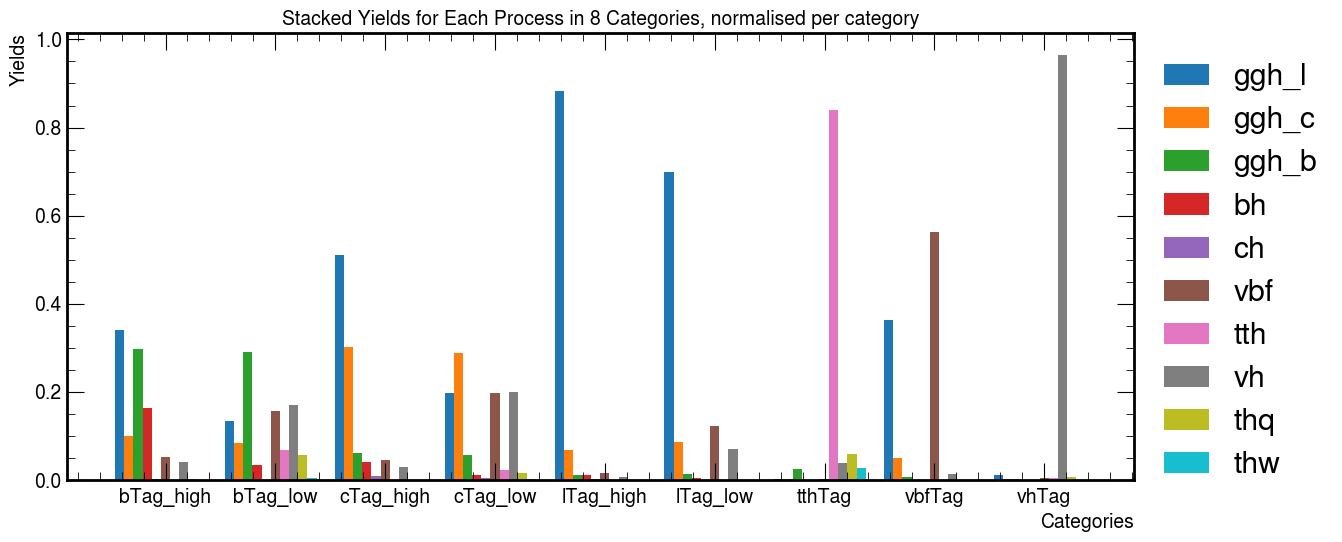

In [45]:
# Number of categories, processes, and yields
n_categories = len([*cat_dict])
n_processes = len([*yields_cats])

# Category labels
categories = [*cat_dict]
samples_ = ["ggh", "bh", "ch", "vbf", "tth", "vh", "thw", "thq"]

# X positions for the categories
x = np.arange(n_categories)

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Initialize the bottom values for each category (to stack yields)
bottoms = np.zeros(n_categories)
tot_categories = np.zeros(n_categories)

i = 0
bar_width = 1 / (n_processes + 2)
x_ticks = np.arange(n_categories)
print (x)
x = x_ticks - ak.ones_like(x) * bar_width * int(n_processes / 2)
print (x)
# Loop over the processes and create stacked bars for each category
for sample in ordered_samples:
    # Stack the 3 yields for each process
    proc = sample.split("_")[0].lower()
    if proc == "ggh":
        for flavour in ["l", "c", "b"]:
            if "l" in flavour:
                lab = "ggh_l"
                mask = (~fileset[sample]["NOTAG"]["bottom_flag_gen"]) & (~fileset[sample]["NOTAG"]["charmed_flag_gen"])
            elif "c" in flavour:
                lab = "ggh_c"
                mask = (~fileset[sample]["NOTAG"]["bottom_flag_gen"]) & (fileset[sample]["NOTAG"]["charmed_flag_gen"])
            else:
                lab = "ggh_b"
                mask = (fileset[sample]["NOTAG"]["bottom_flag_gen"])
            sum_ = []
            events = fileset[sample]["NOTAG"][mask]
            for cat in cat_dict:
                integral = calculate_yields(events, cat_dict[cat])
                sum_.append(integral/cat_dict[cat]["yields_tot"])
            ax.bar(
                x + i * bar_width,             # Same x positions for all processes
                sum_,                          # Sum of yields for the current process
                width=bar_width,               # Bar width for better visibility
                label=f"{proc}_{flavour}"      # Label for each process
            )
            i += 1
    else:
        sum_ = []
        events = fileset[sample]["NOTAG"]
        for cat in cat_dict:
            integral = calculate_yields(events, cat_dict[cat])
            sum_.append(integral/cat_dict[cat]["yields_tot"])
        ax.bar(
            x + i * bar_width,             # Same x positions for all processes
            sum_,                          # Sum of yields for the current process
            width=bar_width,               # Bar width for better visibility
            label=f"{proc}"                  # Label for each process
        )
        i += 1

# Add category labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(categories, fontsize=14)

# Add labels and title
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Yields', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title('Stacked Yields for Each Process in 8 Categories, normalised per category', fontsize=14)

# ax.set_yscale('log')

# Create a legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.savefig(f"yields_proc_norm_cat_{ext}_{dir_ext}.png")
plt.tight_layout()
plt.show()


[0 1 2 3 4 5 6 7 8]
[-0.417, 0.583, 1.58, 2.58, 3.58, 4.58, 5.58, 6.58, 7.58]


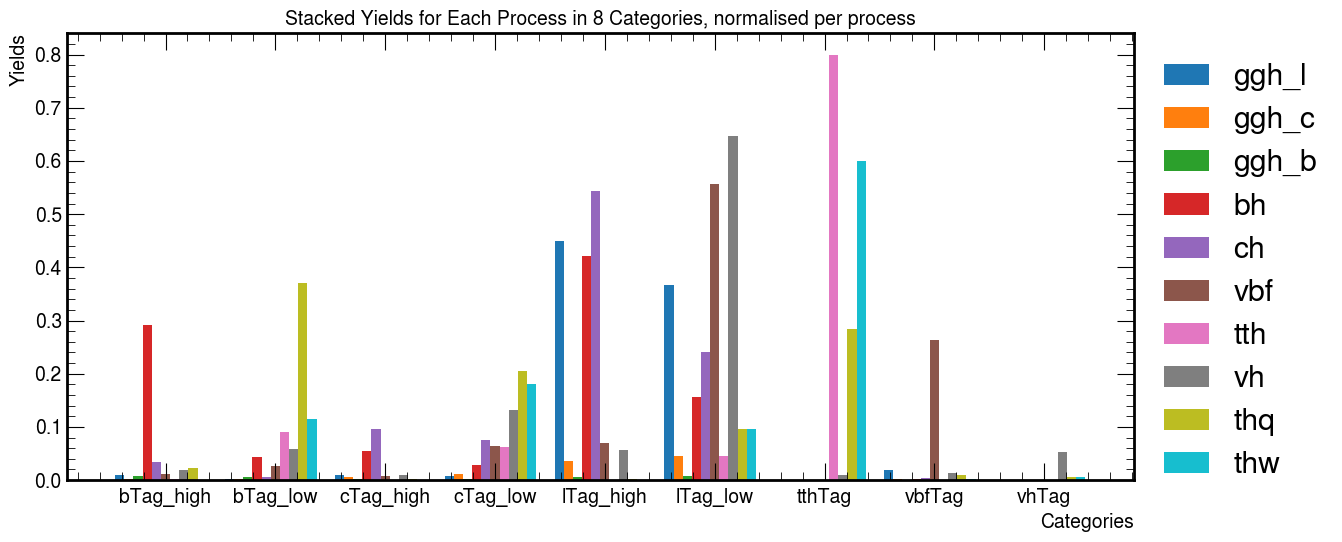

In [46]:
# Number of categories, processes, and yields
n_categories = len([*cat_dict])
n_processes = len([*yields_cats])

# Category labels
categories = [*cat_dict]
samples_ = ["ggh", "bh", "ch", "vbf", "tth", "vh", "thw", "thq"]

# X positions for the categories
x = np.arange(n_categories)

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Initialize the bottom values for each category (to stack yields)
bottoms = np.zeros(n_categories)
tot_categories = np.zeros(n_categories)

i = 0
bar_width = 1 / (n_processes + 2)
x_ticks = np.arange(n_categories)
print (x)
x = x_ticks - ak.ones_like(x) * bar_width * int(n_processes / 2)
print (x)

for sample in ordered_samples:
    proc = sample.split("_")[0].lower()
    if proc == "ggh":
        for flavour in ["l", "c", "b"]:
            if "l" in flavour:
                lab = "ggh_l"
                mask = (~fileset[sample]["NOTAG"]["bottom_flag_gen"]) & (~fileset[sample]["NOTAG"]["charmed_flag_gen"])
            elif "c" in flavour:
                lab = "ggh_c"
                mask = (~fileset[sample]["NOTAG"]["bottom_flag_gen"]) & (fileset[sample]["NOTAG"]["charmed_flag_gen"])
            else:
                lab = "ggh_b"
                mask = (fileset[sample]["NOTAG"]["bottom_flag_gen"])
            events = fileset[sample]["NOTAG"][mask]
            for cat in cat_dict:
                events = fileset[sample]["NOTAG"]
                integral = calculate_yields(events, cat_dict[cat])
                yields_cats[lab] += integral
    else:
        events = fileset[sample]["NOTAG"]
        for cat in cat_dict:
            integral = calculate_yields(events, cat_dict[cat])
            yields_cats[proc] += integral
        
# Loop over the processes and create stacked bars for each category
for sample in ordered_samples:
    # Stack the 3 yields for each process
    proc = sample.split("_")[0].lower()
    if proc == "ggh":
        for flavour in ["l", "c", "b"]:
            if "l" in flavour:
                lab = "ggh_l"
                mask = (~fileset[sample]["NOTAG"]["bottom_flag_gen"]) & (~fileset[sample]["NOTAG"]["charmed_flag_gen"])
            elif "c" in flavour:
                lab = "ggh_c"
                mask = (~fileset[sample]["NOTAG"]["bottom_flag_gen"]) & (fileset[sample]["NOTAG"]["charmed_flag_gen"])
            else:
                lab = "ggh_b"
                mask = (fileset[sample]["NOTAG"]["bottom_flag_gen"])
            sum_ = []
            events = fileset[sample]["NOTAG"][mask]
            for cat in cat_dict:
                integral = calculate_yields(events, cat_dict[cat])
                sum_.append(integral/yields_cats[lab])
            ax.bar(
                x + i * bar_width,             # Same x positions for all processes
                sum_,                          # Sum of yields for the current process
                width=bar_width,               # Bar width for better visibility
                label=lab      # Label for each process
            )
            i += 1
    else:
        sum_ = []
        events = fileset[sample]["NOTAG"]
        for cat in cat_dict:
            integral = calculate_yields(events, cat_dict[cat])
            sum_.append(integral/yields_cats[proc])
        ax.bar(
            x + i * bar_width,             # Same x positions for all processes
            sum_,                          # Sum of yields for the current process
            width=bar_width,               # Bar width for better visibility
            label=f"{proc}"                  # Label for each process
        )
        i += 1

# Add category labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(categories, fontsize=14)

# Add labels and title
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Yields', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title('Stacked Yields for Each Process in 8 Categories, normalised per process', fontsize=14)

# ax.set_yscale('log')

# Create a legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()

plt.savefig(f"yields_norm_proc_{ext}_{dir_ext}.png")
plt.show()

Processing sample: ggh_M125_2018
Processing sample: bH_5FS_FXFX_M125_2018
Processing sample: cH_4FS_FXFX_M125_2018
Processing sample: vbf_M125_2018
Processing sample: tth_M125_2018
Processing sample: vh_M125_2018
Processing sample: THQ_HToGG_2018
Processing sample: THW_HToGG_2018
Process: h_l, Yields: [0.0005854951341419363, 0.08216731532176941, 5.365360908780996e-05, 0.1287435399473486, 5.435507341887607e-06, 0.006874477556827558, 0.42726482483466105, 0.0014276300873494365, 0.004020706904445767]
Process: h_b, Yields: 0
Process: h_c, Yields: 0
Process: vbf, Yields: 0
Process: tth, Yields: 0
Process: vh, Yields: 0
Process: thw, Yields: 0
Process: thq, Yields: 0


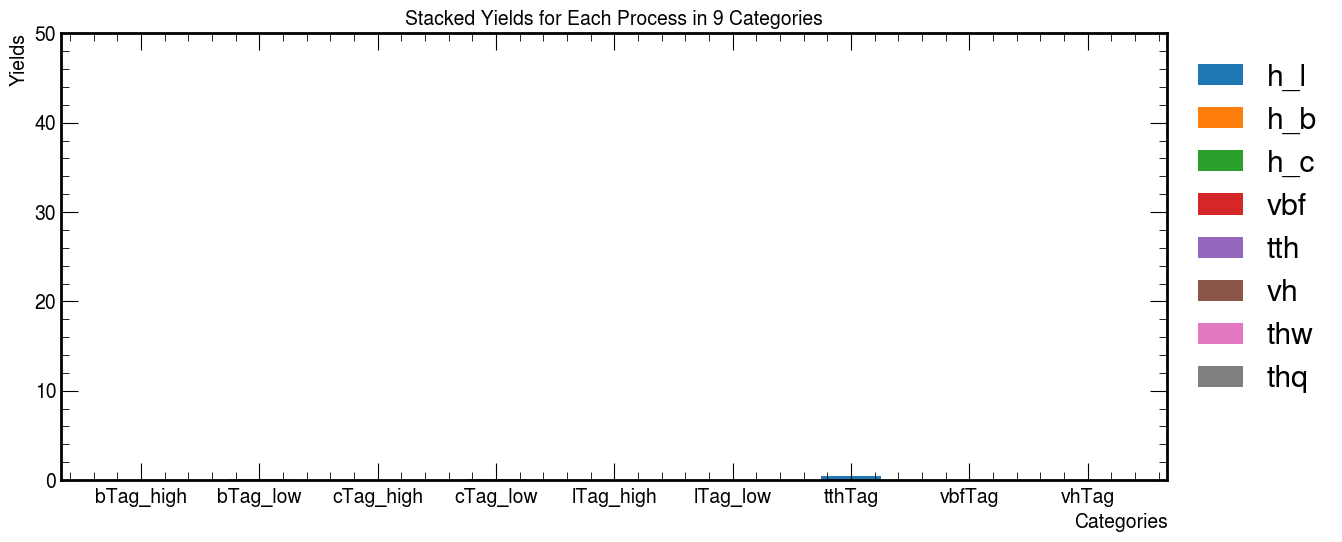

In [ ]:
yields_proc = {
    "h_l" : 0,
    "h_b" : 0,
    "h_c" : 0,
    "vbf" : 0,
    "tth" : 0,
    "vh" : 0,
    "thw" : 0,
    "thq" : 0
}


# Number of categories, processes, and yields
n_categories = len([*cat_dict])
n_processes = 6

# Category labels
categories = [*cat_dict]

# Loop over the processes and create stacked bars for each category
for sample in ordered_samples:
    print(f"Processing sample: {sample}")
    # Stack the 3 yields for each process
    proc = sample.split("_")[0].lower()
    if proc in ["ggh", "ch", "bh"]:
        for flavour in ["l", "c", "b"]:
            if "l" in flavour:
                lab = f"{proc}_l"
                mask = (~fileset[sample]["NOTAG"]["bottom_flag_gen"]) & (~fileset[sample]["NOTAG"]["charmed_flag_gen"])
            elif "c" in flavour:
                lab = f"{proc}_c"
                mask = (~fileset[sample]["NOTAG"]["bottom_flag_gen"]) & (fileset[sample]["NOTAG"]["charmed_flag_gen"])
            else:
                lab = f"{proc}_b"
                mask = (fileset[sample]["NOTAG"]["bottom_flag_gen"])
            sum_ = []
            yields[lab] = {}
            events = fileset[sample]["NOTAG"][mask]
            for cat in cat_dict:
                integral = calculate_yields(events, cat_dict[cat])
                yields[lab][cat] = integral
                if ("lT" in cat):
                    sum_.append(integral/10)
                else:
                    sum_.append(integral)
            if yields_proc[f"h_{flav}"] == 0:
                yields_proc[f"h_{flav}"] = sum_
                print(f"Updated yields for {lab}: {yields_proc[f'h_{flav}']}")
            else:
                yields_proc[f"h_{flav}"] += sum_
                print(f"Updated yields for {lab}: {yields_proc[f'h_{flav}']}")
    else:
        yields[proc] = {}
        sum_ = []
        events = fileset[sample]["NOTAG"]
        for cat in cat_dict:
            integral = calculate_yields(events, cat_dict[cat])
            yields[proc][cat] = integral
            if ("lT" in cat):
                sum_.append(integral/10)
            else:
                sum_.append(integral)
        yields_proc[f"h_{flav}"] = sum_

samples_ = ["h", "vbf", "tth", "vh", "thw", "thq"]

# X positions for the categories
x = np.arange(n_categories)

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Initialize the bottom values for each category (to stack yields)
bottoms = np.zeros(n_categories)
tot_categories = np.zeros(n_categories)


# Loop over the processes and create stacked bars for each category
for k, proc in yields_proc.items():
    print(f"Process: {k}, Yields: {proc}")
    # Stack the 3 yields for each process
    sum_ = proc
    ax.bar(
        x,                      # Same x positions for all processes
        sum_,                    # Sum of yields for the current process
        width=0.5,               # Bar width for better visibility
        bottom=bottoms,          # Start from the accumulated yields
        label=f"{k}"               # Label for each process
    )
    # Update bottoms for stacking
    bottoms += sum_

# Add category labels
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=14)

# Add labels and title
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylim([0, 50])
ax.set_ylabel('Yields', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title(f'Stacked Yields for Each Process in {n_categories} Categories', fontsize=14)

# ax.set_yscale('log')

# Create a legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()

#plt.savefig(f"yields_{ext}_{dir_ext}.png")
plt.show()

In [87]:
for f in fileset[[*processes][0]][[*cats][0]].fields:
    if "eight" not in f and "bdt" in f:
        print(f)

bdt_score
ch_vs_ggh_bdt_score
ch_vs_cb_bdt_score
ggh_vs_hb_bdt_sig_score
ggh_vs_hb_bdt_tth_score
ggh_vs_hb_bdt_vh_score
ggh_vs_hb_bdt_vbf_score
diph_bdt_sig_score
diph_bdt_fk_score
diph_bdt_ph_score


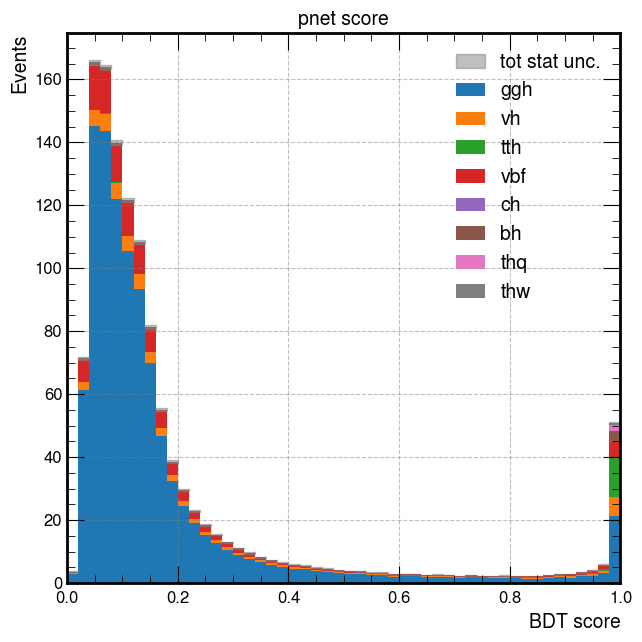

In [344]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 7))

title = "pnet score"
var = "first_jet_jet_pn_b_plus_c"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["thw", "thq", "bh", "ch", "vbf", "tth", "vh",  "ggh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            filter = (
                fileset[sample][cat]["bdt_score"] > 0.
            )
            full_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()

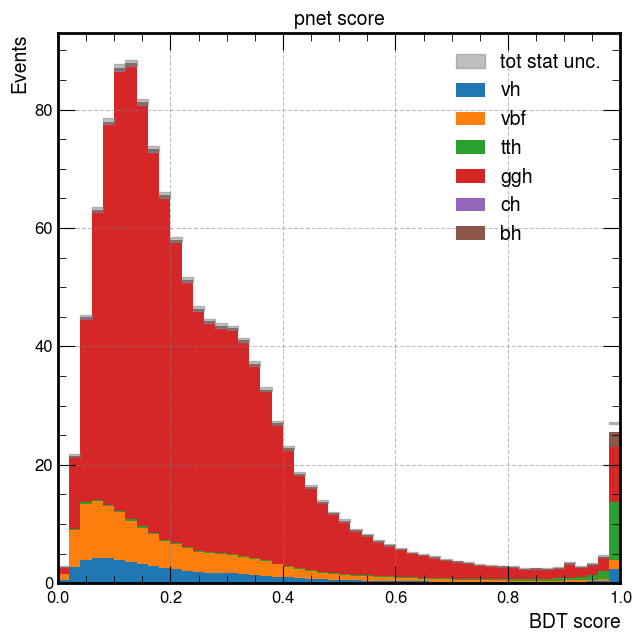

In [48]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 7))

title = "pnet score"
var = "first_jet_jet_pn_b_vs_c"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory([ "bh", "ch", "ggh", "tth", "vbf", "vh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            filter = (
                fileset[sample][cat]["bdt_score"] > 0.
            )
            full_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()

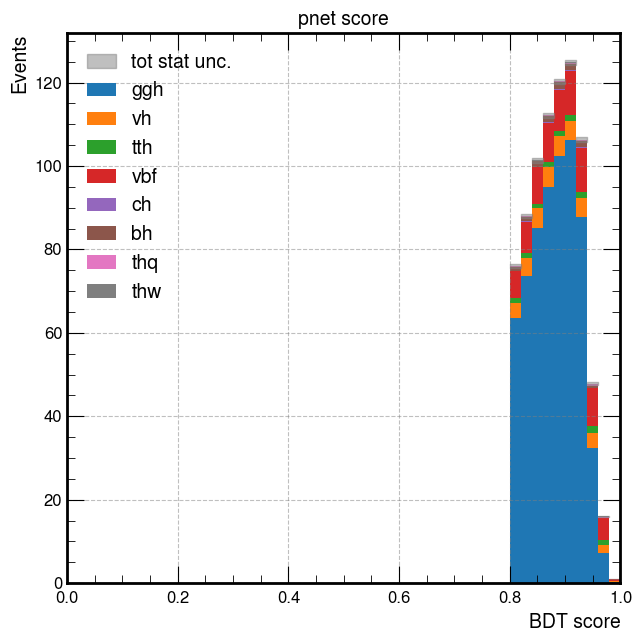

In [49]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 7))

title = "pnet score"
var = "bdt_score"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["thw", "thq", "bh", "ch", "vbf", "tth", "vh",  "ggh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            filter = (
                fileset[sample][cat]["bdt_score"] > 0.8
            )
            full_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()

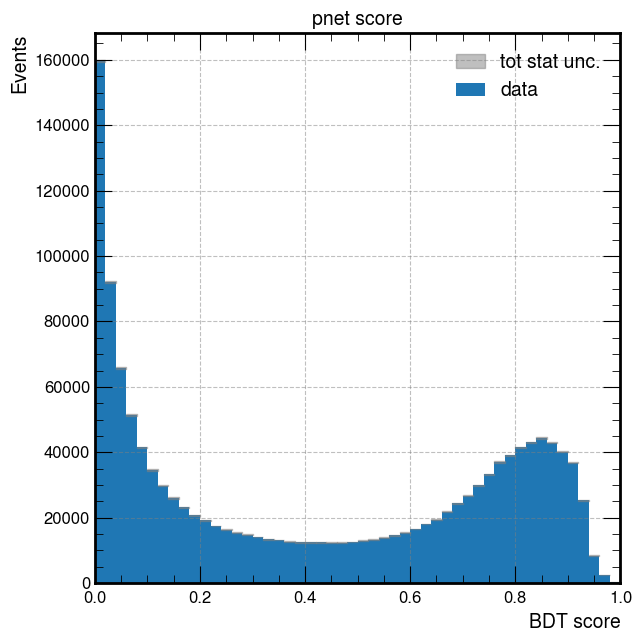

In [50]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 7))

title = "pnet score"
var = "bdt_score"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["data"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for cat in cats:
    if len(fileset_data[cat].weight) > 1:
        filter = (
            fileset_data[cat]["bdt_score"] > 0.
        )
        full_hist.fill(ax = fileset_data[cat][var][filter], weight = fileset_data[cat]["weight"][filter], c="data")
        full_hist_err.fill(ax = fileset_data[cat][var][filter], weight = fileset_data[cat]["weight"][filter], c="data")
        tot_hist.fill(ax = fileset_data[cat][var][filter], weight = fileset_data[cat]["weight"][filter], c="tot")
        tot_hist_err.fill(ax = fileset_data[cat][var][filter], weight = fileset_data[cat]["weight"][filter], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()

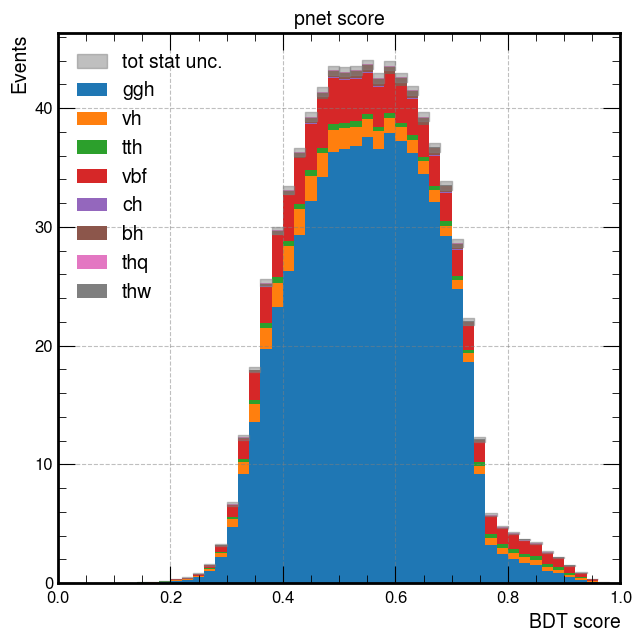

In [51]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 7))

title = "pnet score"
var = "diph_bdt_sig_score"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["thw", "thq", "bh", "ch", "vbf", "tth", "vh",  "ggh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            filter = (
                fileset[sample][cat]["bdt_score"] > 0.8
            )
            full_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()

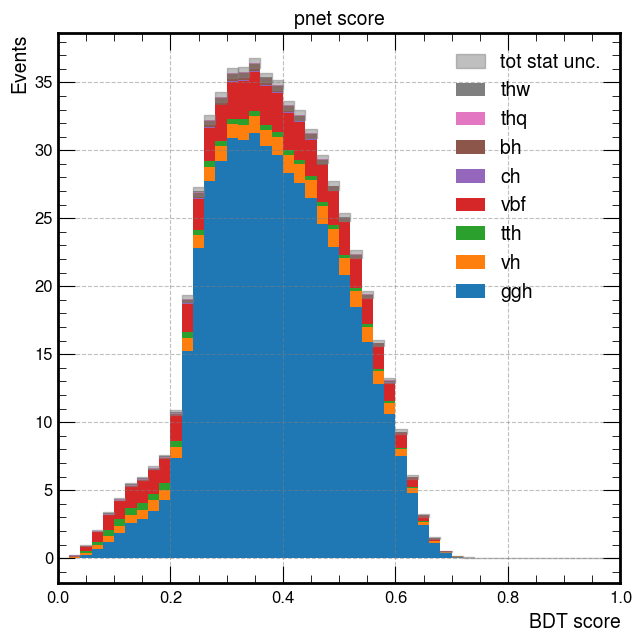

In [48]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 7))

title = "pnet score"
var = "diph_bdt_fk_score"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["thw", "thq", "bh", "ch", "vbf", "tth", "vh",  "ggh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            filter = (
                fileset[sample][cat]["bdt_score"] > 0.8
            )
            full_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()

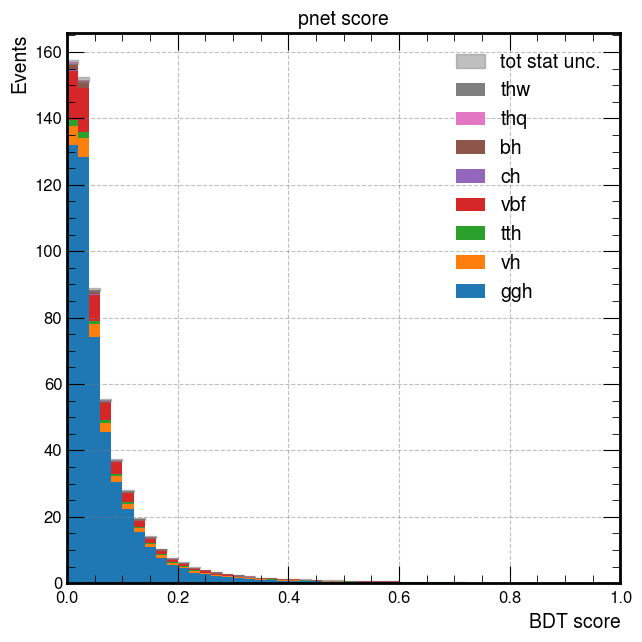

In [49]:
# lead photon eta
fig, ax0 = plt.subplots(1,1, figsize=(7, 7))

title = "pnet score"
var = "diph_bdt_ph_score"
min_ = 0.
max_ = 1
nbins = 50


LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["thw", "thq", "bh", "ch", "vbf", "tth", "vh",  "ggh"], name="c")
LeadPhoton_et_cax_tot = hist.axis.StrCategory(["tot"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
tot_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)
tot_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax_tot)

for sample in [*fileset]:
    for cat in cats:
        if len(fileset[sample][cat].weight) > 1:
            filter = (
                fileset[sample][cat]["bdt_score"] > 0.8
            )
            full_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c=sample.split("_")[0].lower())
            full_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c=sample.split("_")[0].lower())
            tot_hist.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["weight_norm"][filter], c="tot")
            tot_hist_err.fill(ax = fileset[sample][cat][var][filter], weight = fileset[sample][cat]["square_weight"][filter], c="tot")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

stack = True
h_stack[::-1].plot(ax=ax0, stack=stack, histtype="fill")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

tot = {}
tot["bins"] = {}
tot["errs"] = {}
tot["edges"] = {}


# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in [*full_hist.axes[1]]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])

for sample in [*tot_hist.axes[1]]:
    tot["bins"][sample], tot["edges"][sample] = tot_hist[:,sample].to_numpy()
    tot["edges"][sample] = tot["edges"][sample] + half_bin
    tot["errs"][sample] = np.sqrt(tot_hist_err[:,sample].to_numpy()[0])

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
for sample in [*full_hist.axes[1]]:
    ydn[sample] = [mc["bins"][sample][i] - x for i, x in enumerate(mc["errs"][sample])]
    yup[sample] = [mc["bins"][sample][i] + x for i, x in enumerate(mc["errs"][sample])]
for sample in [*tot_hist.axes[1]]:
    ydn[sample] = [tot["bins"][sample][i] - x for i, x in enumerate(tot["errs"][sample])]
    yup[sample] = [tot["bins"][sample][i] + x for i, x in enumerate(tot["errs"][sample])]


# plot shaded area for MC errors
colours = acab_palette
for j, sample in enumerate([*full_hist.axes[1]]):
    if stack: break
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
for sample in [*tot_hist.axes[1]]:
    if not stack: break
    for i, x in enumerate(tot["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor="grey", alpha=0.5, edgecolor="grey", label="")

# cosmetics
ax0.set_ylabel('Events', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# Style
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles[::-1], labels[::-1], prop={'size': 14})
#hep.cms.label()


ax0.set_xlim([min_, max_])
ax0.set_xlabel('BDT score', fontsize=14)
ax0.tick_params(axis='x', labelsize=12)
ax0.tick_params(axis='y', labelsize=12)
plt.tight_layout()
    
plt.plot()
plt.show()